In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import re 
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# I. EDA individual dataframes

## 1. Applications (train)

### 1.1 Overview of the data

In [2]:
application_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
application_train.shape

(307511, 122)

In [4]:
# Essential functions
def check_missing_data(df): # function to count number of nans in each column and percentage of nans in that columns
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/len(df)) *100).sort_values(ascending = False)
    res = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    res = res[res["Total"] != 0]
    return res


def find_high_corr_pair(df): # finding highly correlated pairs in a dataframe
    corr_matrix = df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    temp = []
    for col in upper.columns:
        for ind in upper.index:
            if upper.loc[ind, col] > 0.9:
                temp.append((col, ind))
    return temp # return a list of tuples with highly correlated pair

# find descriptions of a column

def search_description(col_name, table_name):
    description = pd.read_csv("../input/home-credit-default-risk/HomeCredit_columns_description.csv", encoding= "ISO-8859-1")
    description = description[description["Table"] == table_name][["Row", "Description"]]
    return description[description["Row"] == col_name].values

def remove_outliers_iqr(df, column):
    q75, q25 = np.percentile(df[column], [75 ,25])
    IQR = q75 - q25
    fence_low = q25 - 1.5 * IQR 
    fence_high = q75 + 1.5 * IQR
    df_out = df.loc[(df[column] < fence_low) | (df[column] > fence_high)]
    df[column].iloc[df_out.index] = np.nan
    return df

def plot_numeric_dist_boxplot(table, column):
    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.boxplot(previous_application[column], color= 'g')

def count_outliers_iqr(df, column):
    q75, q25 = np.percentile(df[column], [75 ,25])
    IQR = q75 - q25
    fence_low = q25 - 1.5 * IQR 
    fence_high = q75 + 1.5 * IQR
    df_out = df.loc[(df[column] < fence_low) | (df[column] > fence_high)]
    return len(df_out)

def plot_numeric_dist(table, column):
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {column}")
    ax = sns.distplot(table[column])
    
def delete_spine2(ax):
    for i in ["top", "right"]:
        ax.spines[i].set_visible(False)

In [5]:
check_missing_data(application_train)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [6]:
print(f"duplicated rows in application_train: {application_train.duplicated().sum()}")

duplicated rows in application_train: 0


In [7]:
application_train.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### 1.2 Data exploration

### 1.2.1 Distribution of some categorical variables

TARGET (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample (Deliquency or Default), 0 - all other cases)

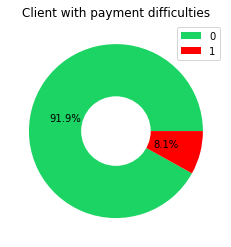

In [8]:
# Pie Chart
temp = application_train["TARGET"].value_counts()
plt.pie(temp.values, autopct='%1.1f%%', colors=['#1cd464', 'red'])
# draw circle
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
# Adding Title of chart
plt.title('Client with payment difficulties')
# Add Legends
plt.legend(temp.index, loc="upper right")
# Displaying Chart
plt.show()

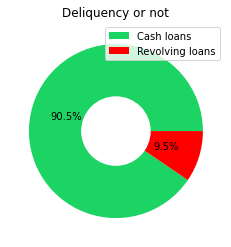

In [9]:
# Distribution of NAME_CONTRACT_TYPE: Types of loan:Identification if loan is cash or revolving(khoản vay xoay vòng)
temp = application_train['NAME_CONTRACT_TYPE'].value_counts()
plt.pie(temp.values, autopct='%1.1f%%', colors=['#1cd464', 'red'])
# draw circle
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
# Adding Title of chart
plt.title('Deliquency or not')
# Add Legends
plt.legend(temp.index, loc="upper right")
# Displaying Chart
plt.show()

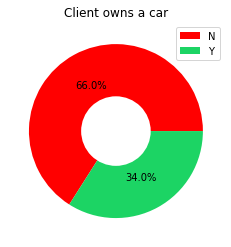

In [10]:
# 7. Distribution of FLAG_OWN_CAR: Purpose of loan: Flag if the client owns a car

temp = application_train["FLAG_OWN_CAR"].value_counts()
plt.pie(temp.values, autopct='%1.1f%%', colors=['red', '#1cd464'])
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Client owns a car')
# Add Legends
plt.legend(temp.index, loc="upper right")

plt.show()

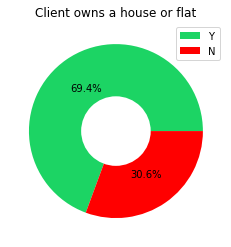

In [11]:
#                    FLAG_OWN_REALTY: Flag if client owns a house or flat
temp = application_train["FLAG_OWN_REALTY"].value_counts()
plt.pie(temp.values, autopct='%1.1f%%', colors=['#1cd464', 'red'])
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Client owns a house or flat')
# Add Legends
plt.legend(temp.index, loc="upper right")

plt.show()

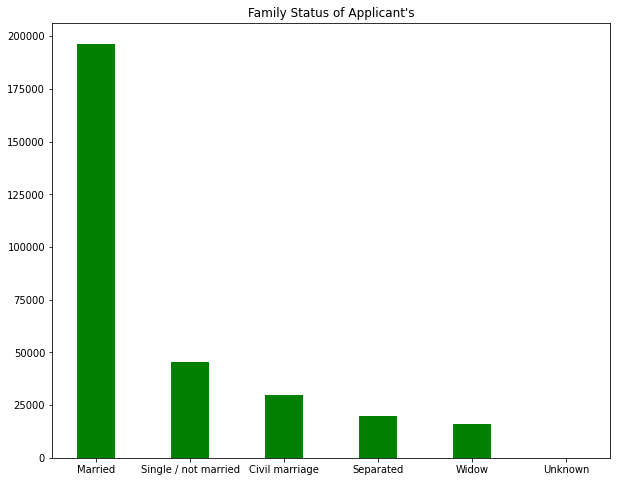

In [12]:
# Distribution of NAME_FAMILY_STATUS: Family Status of Applicant's who applied for loan
temp = application_train['NAME_FAMILY_STATUS'].value_counts()
fig = plt.figure(figsize = (10, 8))
plt.bar(temp.index, temp.values, color = 'green', width = 0.4)
plt.title('Family Status of Applicant\'s')
plt.show()

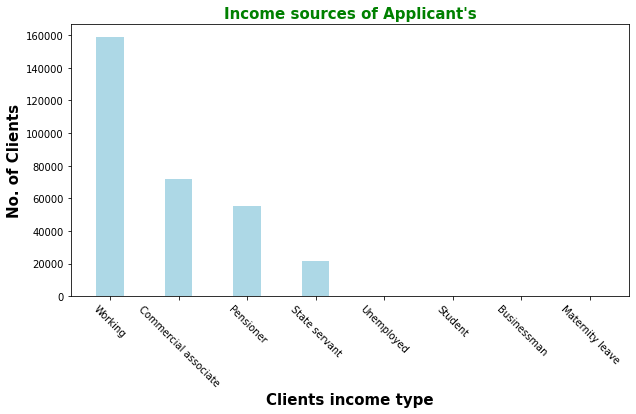

In [13]:
# Distribution of NAME_INCOME_TYPE: Income sources of Applicant's who applied for loan
# Clients income type (businessman, working, maternity leave,..)
temp = application_train["NAME_INCOME_TYPE"].value_counts()
fig = plt.figure(figsize = (10, 5))
 # creating the bar plot
plt.bar(temp.index, temp.values, color ='lightblue',width = 0.4)
 
plt.xticks(temp.index, rotation = -45)
plt.xlabel('Clients income type', fontweight ='bold', fontsize = 15)
plt.ylabel("No. of Clients", fontweight ='bold', fontsize = 15)
plt.title('Income sources of Applicant\'s', fontweight ='bold', fontsize = 15, color = 'green')
plt.show()

Text(10000, 20, "Occupation of Applicant's who applied for loan")

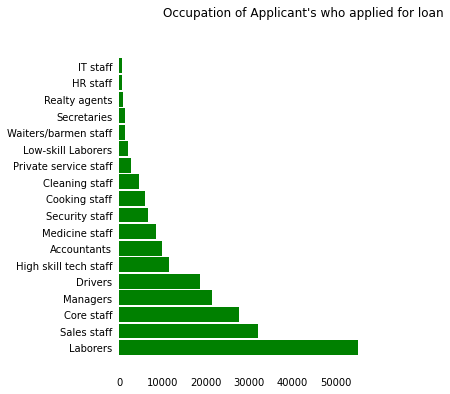

In [14]:
# Distribution of OCCUPATION_TYPE: Occupation of Applicant's who applied for loan
temp = application_train["OCCUPATION_TYPE"].value_counts()
fig, ax = plt.subplots(figsize = (4.5, 6))          
ax.barh(temp.index, temp.values, height = 0.9, color = 'green')
l = ['left', 'right', 'top', 'bottom']
for i in l:
    ax.spines[i].set_visible(False)
#ax.xaxis.tick_top()
#xoa vach diem chia
ax.tick_params(left = False, bottom = False)
ax.text(x= 10000, y = 20, s = 'Occupation of Applicant\'s who applied for loan', size = 12)

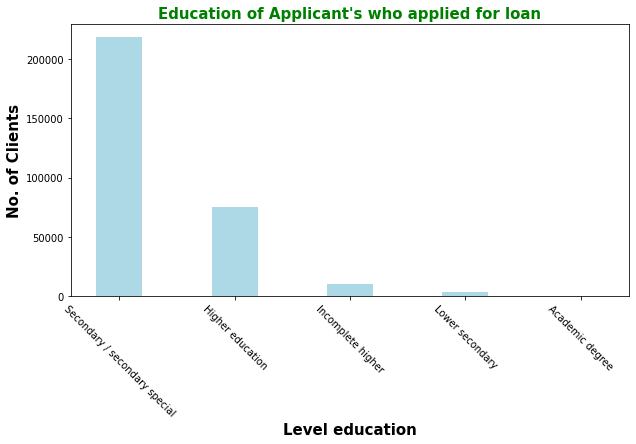

In [15]:

# Distribution of NAME_EDUCATION_TYPE: Education of Applicant's who applied for loan
temp = application_train["NAME_EDUCATION_TYPE"].value_counts()
fig = plt.figure(figsize = (10, 5))

plt.bar(temp.index, temp.values, color ='lightblue',width = 0.4)
 
plt.xticks(temp.index, rotation = -45)
plt.xlabel('Level education', fontweight ='bold', fontsize = 15)
plt.ylabel("No. of Clients", fontweight ='bold', fontsize = 15)
plt.title('Education of Applicant\'s who applied for loan', fontweight ='bold', fontsize = 15, color = 'green')
plt.show()

Text(0, 0.5, 'Organization Name')

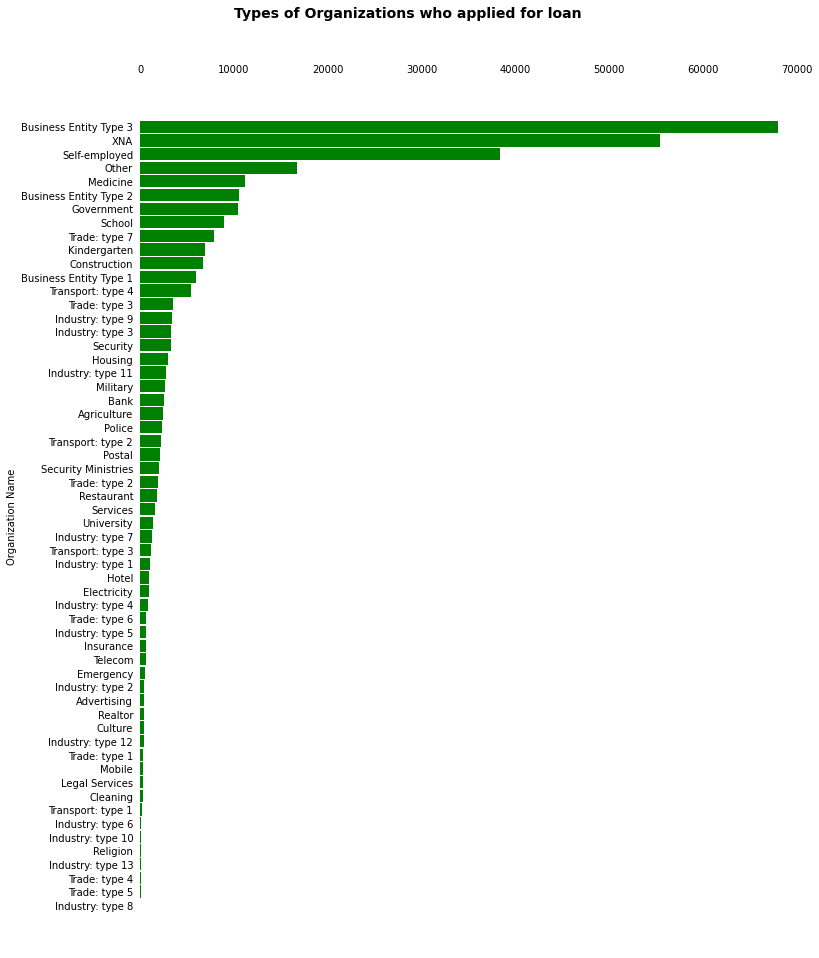

In [16]:
# Distribution of ORGANIZATION_TYPE: types of Organizations who applied for loan
temp = application_train["ORGANIZATION_TYPE"].value_counts().sort_values()
fig, ax = plt.subplots(figsize = (12, 16))          
ax.barh(temp.index, temp.values, height = 0.9, color = 'green')
l = ['left', 'right', 'top', 'bottom']
for i in l:
    ax.spines[i].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(left = False, top = False)
ax.text(x= 10000, y = 65, s = 'Types of Organizations who applied for loan', size = 14, weight = 'bold')
ax.set_ylabel('Organization Name')

In [17]:
search_description("NAME_HOUSING_TYPE", "application_{train|test}.csv")

array([['NAME_HOUSING_TYPE',
        'What is the housing situation of the client (renting, living with parents, ...)']],
      dtype=object)

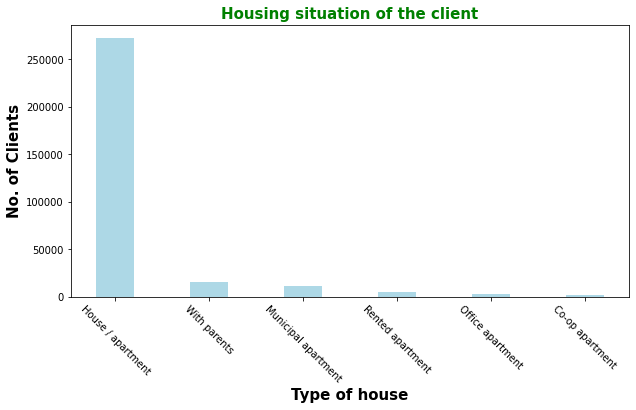

In [18]:

# Clients income type (businessman, working, maternity leave,..)
temp = application_train["NAME_HOUSING_TYPE"].value_counts()

fig = plt.figure(figsize = (10, 5))
 # creating the bar plot
plt.bar(temp.index, temp.values, color ='lightblue',width = 0.4)
 
plt.xticks(temp.index, rotation = -45)
plt.xlabel('Type of house', fontweight ='bold', fontsize = 15)
plt.ylabel("No. of Clients", fontweight ='bold', fontsize = 15)
plt.title('Housing situation of the client', fontweight ='bold', fontsize = 15, color = 'green')
plt.show()

#### 1.2.2 Distribution of AMT varibles (continuous features related to amount of money)

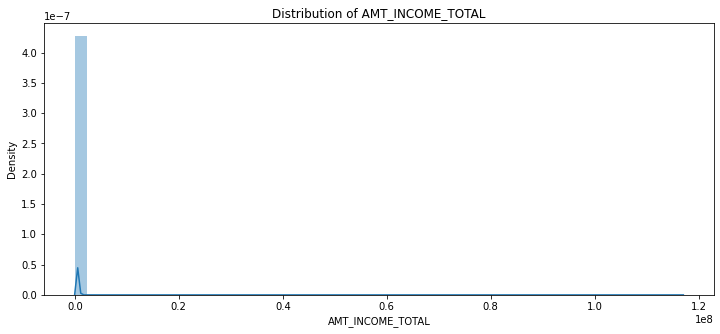

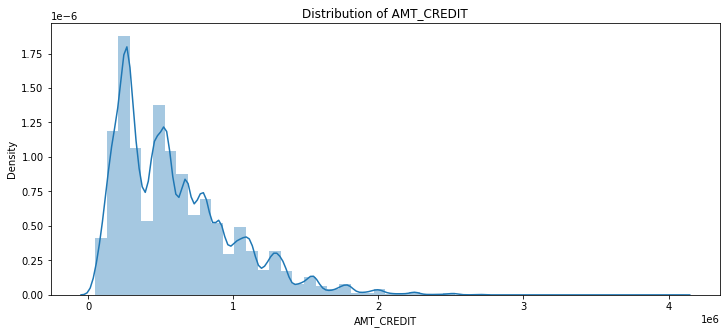

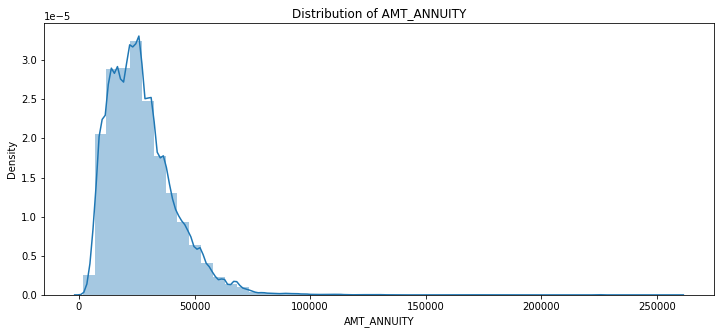

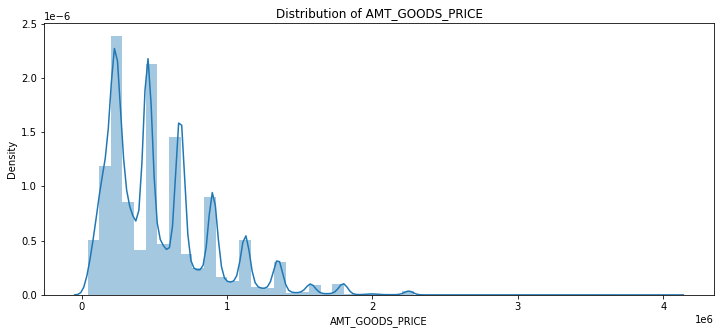

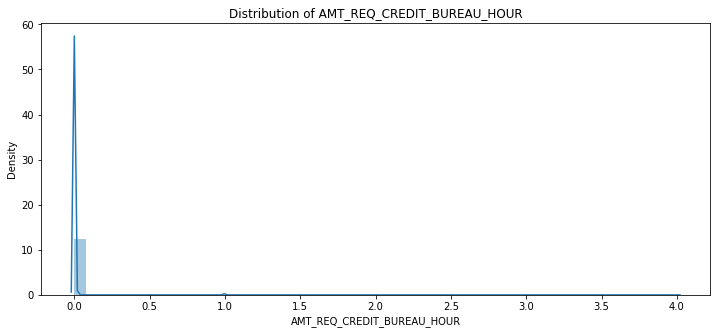

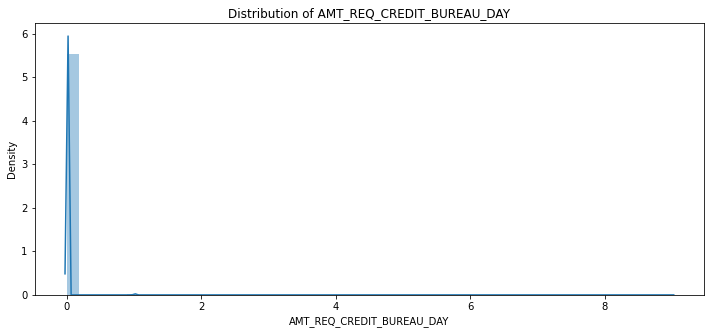

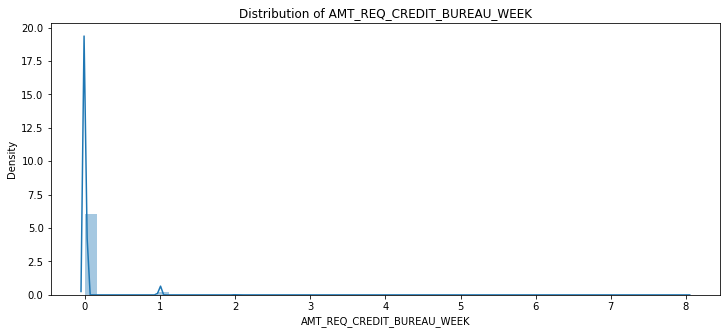

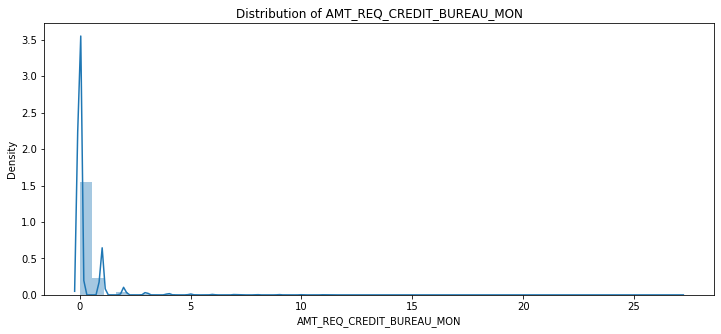

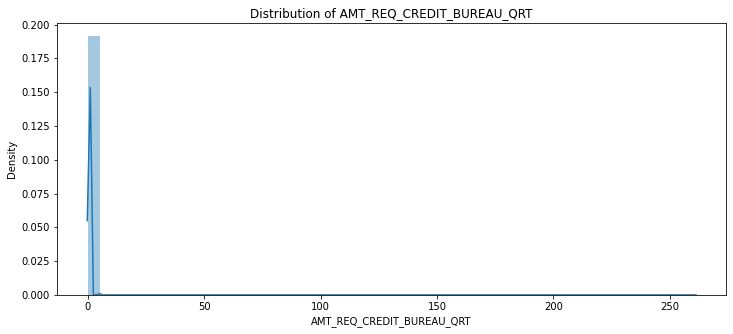

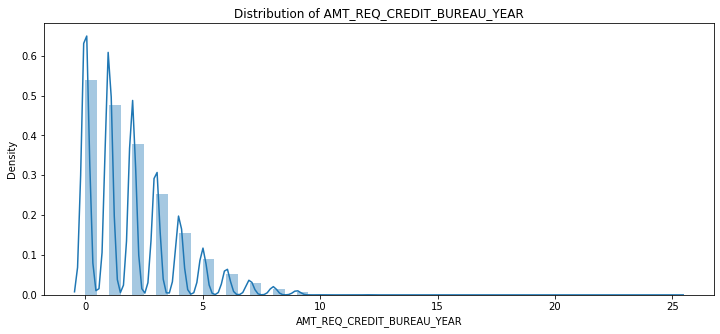

In [19]:
for i in application_train.filter(regex = "AMT_").columns:
    plot_numeric_dist(application_train, i)

### 1.3 Correlation matrix between features

<AxesSubplot:>

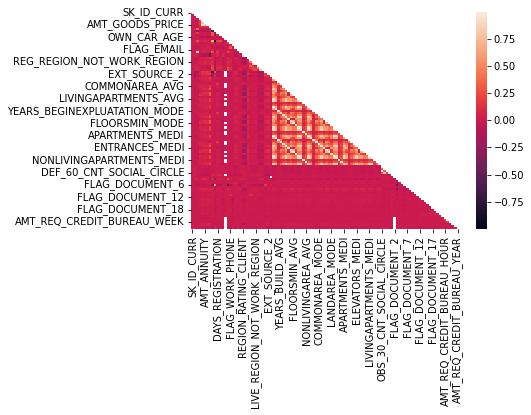

In [20]:
mask = np.triu(np.ones_like(application_train.corr()))
sns.heatmap(application_train.corr(), mask = mask)

In [21]:
# Create correlation matrix
corr_matrix = application_train.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.85
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(to_drop)
# Drop features 
application_train.drop(to_drop, axis=1, inplace=True)
print(application_train.shape)

['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
(307511, 84)


## 2. Bureau and Bureau balance

### 2.1 Overview of the data

This table talks about the Loan data of each unique customer with all financial institutions other than Home Credit For each unique SK_ID_CURR we have multiple SK_ID_BUREAU Id's, each being a unique loan transaction from other financial institutions availed by the same customer and reported to the bureau.

In [22]:
path = '/kaggle/input/home-credit-default-risk/'
bureau_df = pd.read_csv(path + 'bureau.csv')
bureau_balance_df = pd.read_csv(path + 'bureau_balance.csv')
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [23]:
bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [24]:
bureau_df.nunique()

SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [25]:
check_missing_data(bureau_df)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757


In [26]:
bureau_df.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [27]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [28]:
bureau_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [29]:
bureau_balance_df.nunique()

SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64

In [30]:
check_missing_data(bureau_balance_df) #-> do not have missing value

,Total,Percent


In [31]:
print(f"duplicated rows in bureau_balance: {bureau_balance_df.duplicated().sum()}")
print(f"duplicated rows in bureau: {bureau_df.duplicated().sum()}")

duplicated rows in bureau_balance: 0
duplicated rows in bureau: 0


In [32]:
bureau_balance_df["MONTHS_BALANCE"].describe()

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64

In [33]:
bureau_balance_df["STATUS"].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

### 2.2 Bureau_df: data exploration

This table talks about the Loan data of each unique customer with all financial institutions other than Home Credit For each unique SK_ID_CURR we have multiple SK_ID_BUREAU Id's, each being a unique loan transaction from other financial institutions availed by the same customer and reported to the bureau.
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
CREDIT_ACTIVE - Current status of a Loan

CREDIT_CURRENCY - Currency in which the transaction was executed - Currency1, Currency2, Currency3, Currency4 ( 4 values)

DAYS_CREDIT - Number of days ELAPSED since customer applied for CB credit with respect to current application Interpretation - Are these loans evenly spaced time intervals? Are they concentrated within a same time frame?

CREDIT_DAY_OVERDUE - Number of overdue days

CREDIT_TYPE - Consumer Credit, Credit card, Mortgage, Car loan, Microloan, Loan for working capital replemishment, Loan for Business development, Real estate loan, Unkown type of laon, Another type of loan. Cash loan, Loan for the purchase of equipment, Mobile operator loan, Interbank credit, Loan for purchase of shares ( 15 values )

DAYS_CREDIT_ENDDATE - Number of days the customer CREDIT is valid at the time of application

DAYS_ENDDATE_FACT - Days since CB credit ended at the time of application

AMT_CREDIT_MAX_OVERDUE - Maximum Credit amount overdue at the time of application

CNT_CREDIT_PROLONG - How many times was the Credit date prolonged

AMT_CREDIT_SUM - Total available credit for a customer

AMT_CREDIT_SUM_DEBT - Total amount yet to be repayed

AMT_CREDIT_SUM_LIMIT - Current Credit that has been utilized

For a given loan transaction 'AMT_CREDIT_SUM' = 'AMT_CREDIT_SUM_DEBT' +'AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE - Current credit payment that is overdue

DAYS_CREDIT_UPDATE - Number of days before current application when last CREDIT UPDATE was received

AMT_ANNUITY - Annuity of the Credit Bureau data

 #### 2.2.1 Plot object features

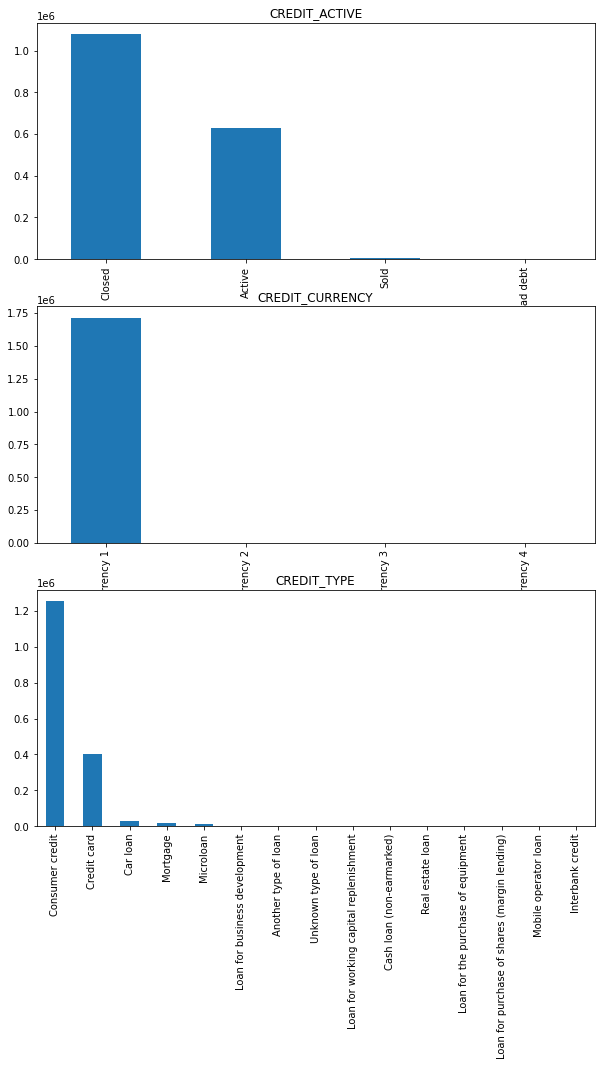

In [34]:

columns_obj = bureau_df.select_dtypes('object').columns
def plot_bar(cols):
    bureau_df[cols].value_counts().plot(kind='bar')

plt.figure(figsize = (10,20))    
for i in range(1, 4, 1):
    plt.subplot(4, 1, i)
    plot_bar(columns_obj[i-1])
    plt.title(columns_obj[i-1])

Comment:

* The majority of credits are either closed or active.
* One currency dominates all credits. Maybe its USD.
* The majority of loans are consumer credits or credit card. Then car loans and mortgage loans come after.

#### 2.2.2 plot numeric features

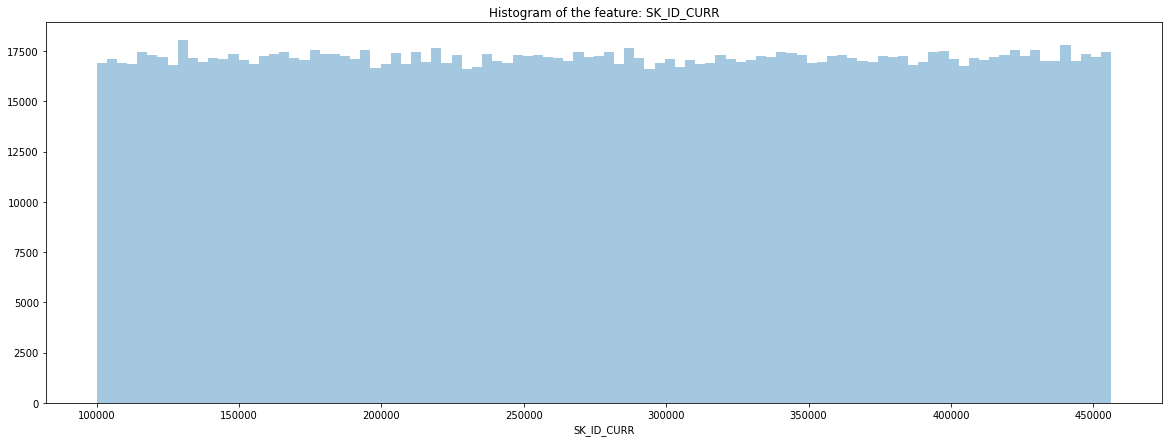

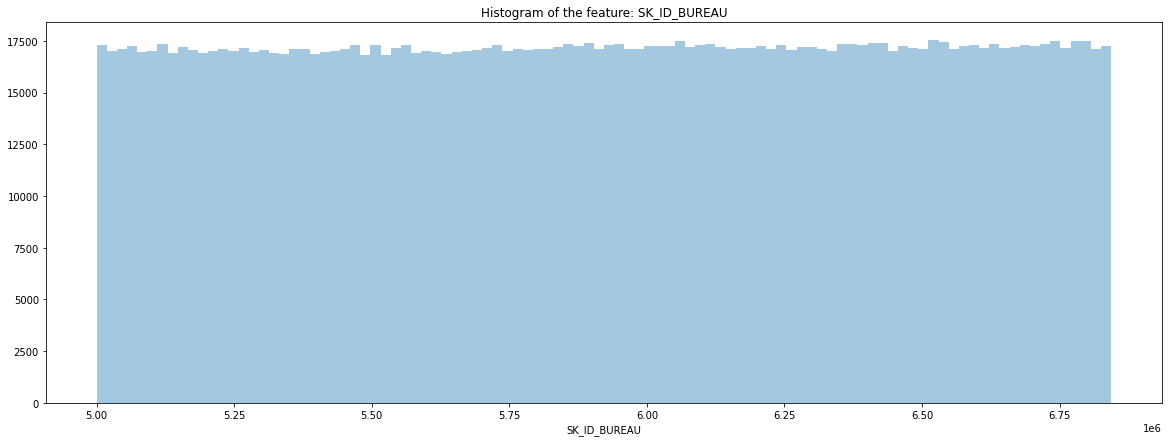

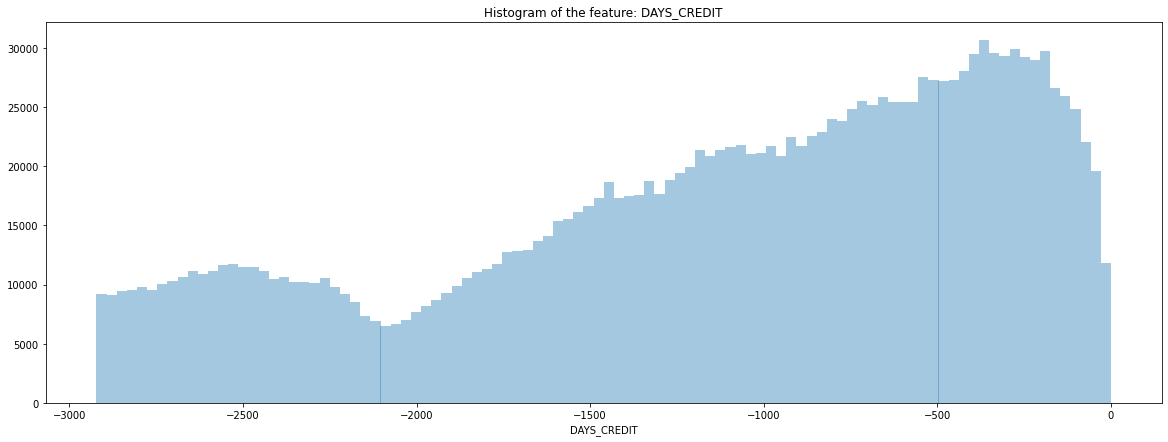

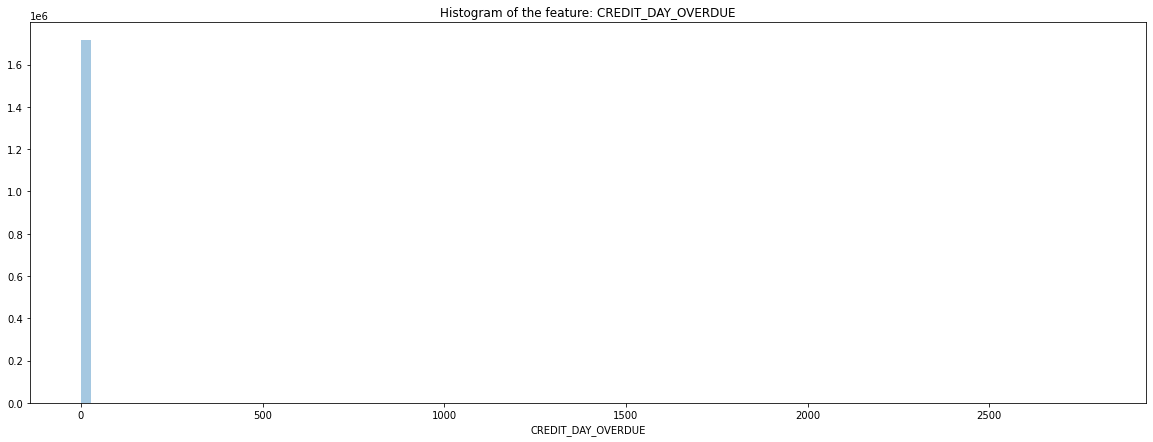

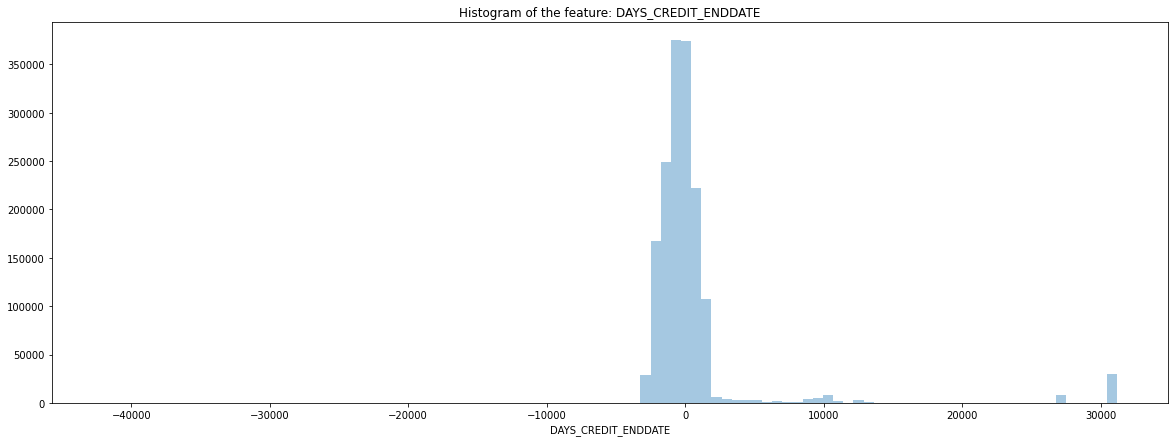

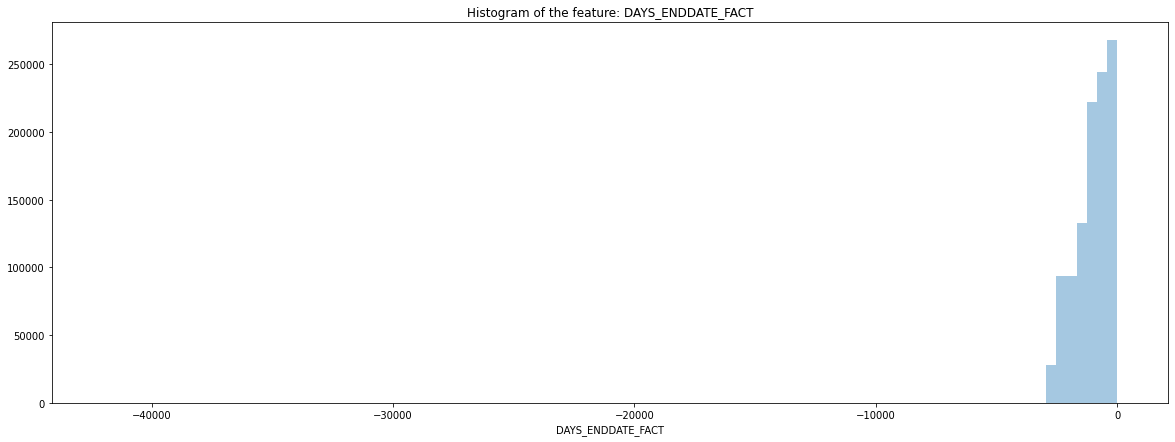

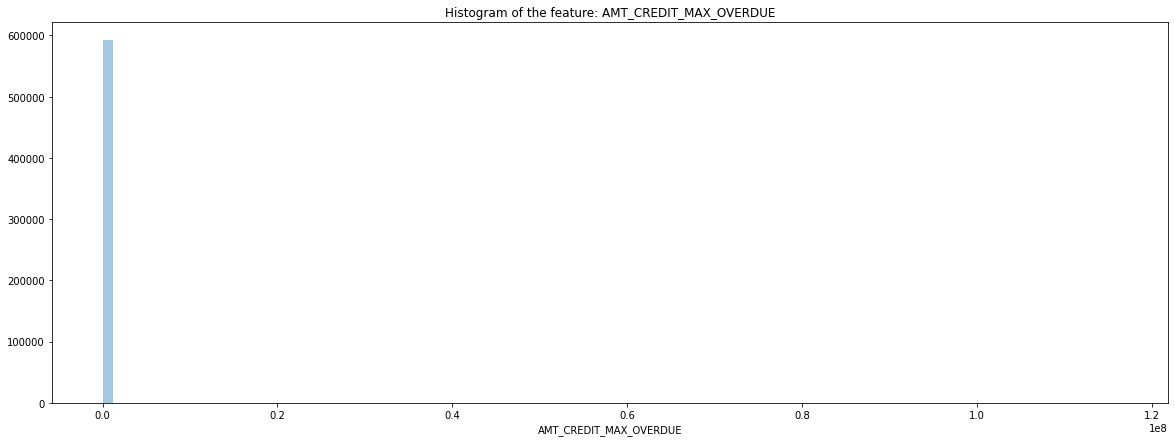

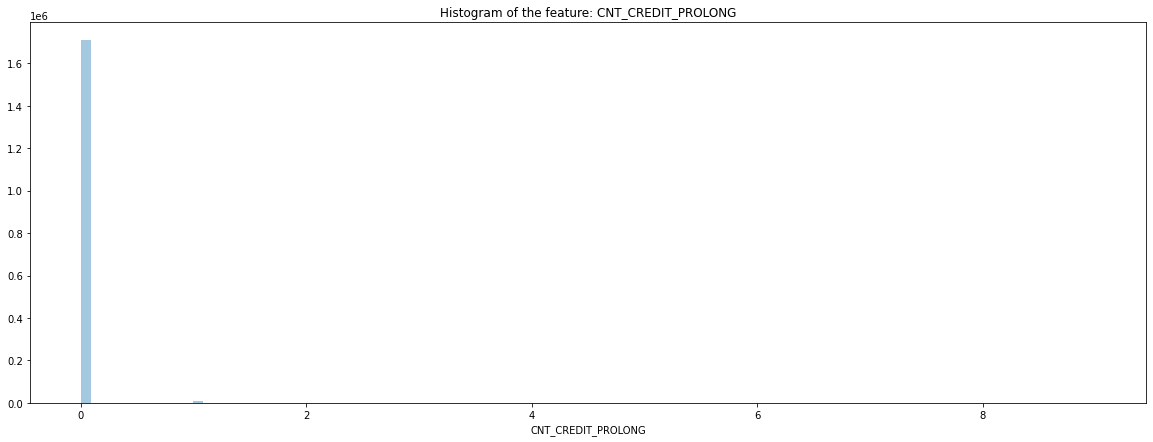

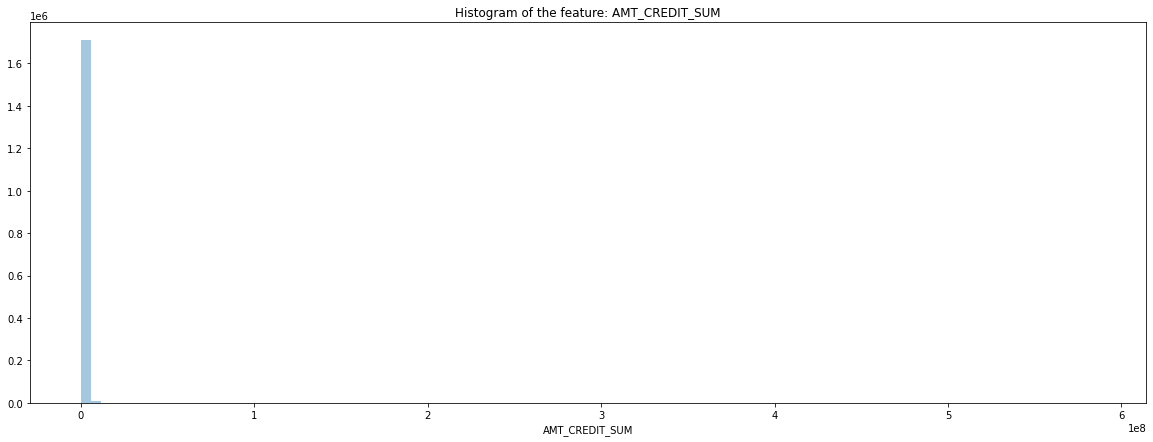

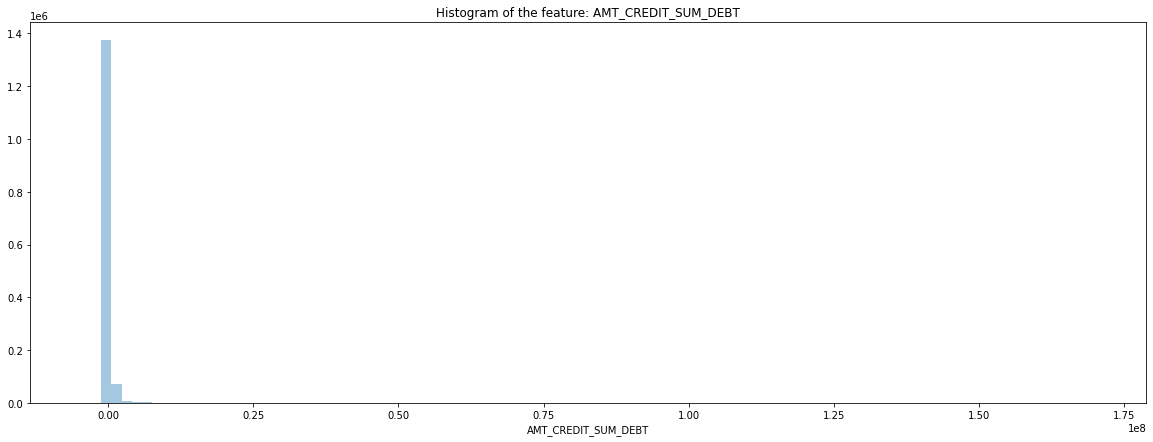

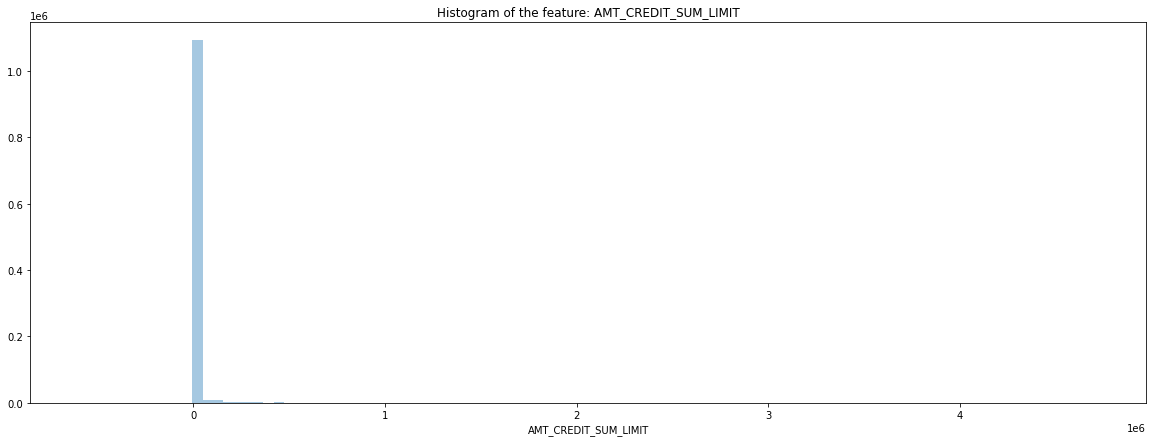

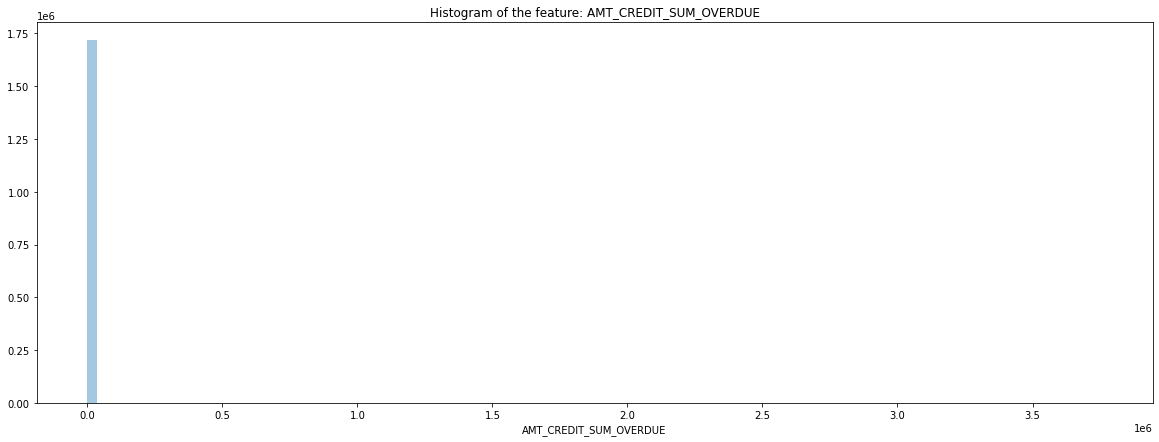

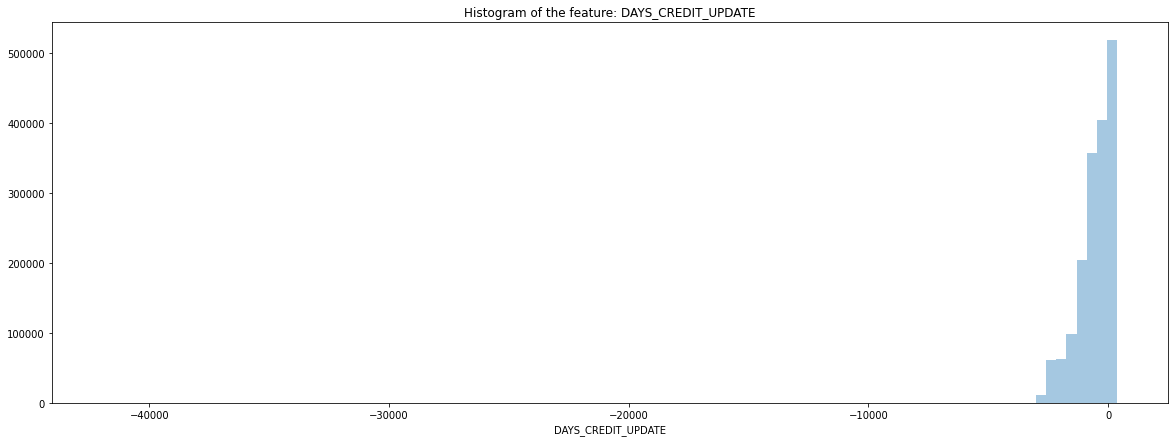

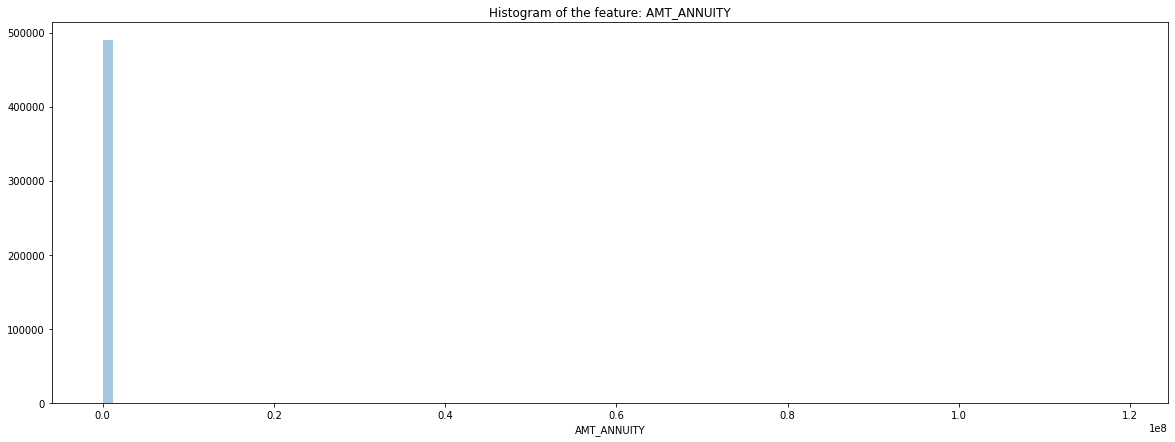

In [35]:
numeric_col = bureau_df.select_dtypes(exclude='object').columns
for feature in numeric_col:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(bureau_df[feature].dropna(), kde = False, bins = 100, ax = ax)

    ax.set_title("Histogram of the feature: " + feature)

Comment: They are a lot of outliers, especially for features: CREDIT_DAY_OVERDUE, AMT_CREDIT_SUM_DEBT, AMT_ANNUITY, AMT_CREDIT_SUM, DAYS_CREDIT_ENDDATE, AMT_CREDIT_SUM_LIMIT, CNT_CREDIT_PROLONG, DAYS_ENDDATE_FACT, AMT_CREDIT_SUM_OVERDUE, AMT_CREDIT_MAX_OVERDUE, DAYS_CREDIT_UPDATE

### 2.3 BUREAU BALANCE

In [36]:
search_description("STATUS", "bureau_balance.csv")

array([['STATUS',
        'Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )']],
      dtype=object)

In [37]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample # of relative previous credits # of months where we have some history observable for the previous credits) rows.

* MONTHS_BALANCE: Month of balance relative to application date (-1 means the freshest balance date).
* STATUS: "Status of Credit Bureau loan during the month ('Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ])

<AxesSubplot:>

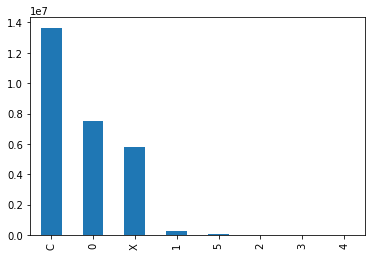

In [38]:
bureau_balance_df['STATUS'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='MONTHS_BALANCE', ylabel='Density'>

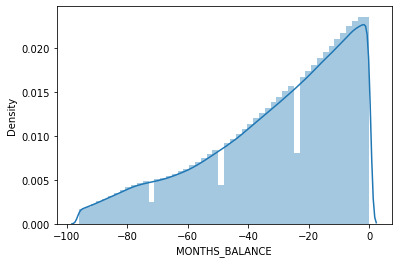

In [39]:
 sns.distplot(bureau_balance_df['MONTHS_BALANCE'].dropna())

Text(0.5, 1.0, 'Correlation plot between numerical features')

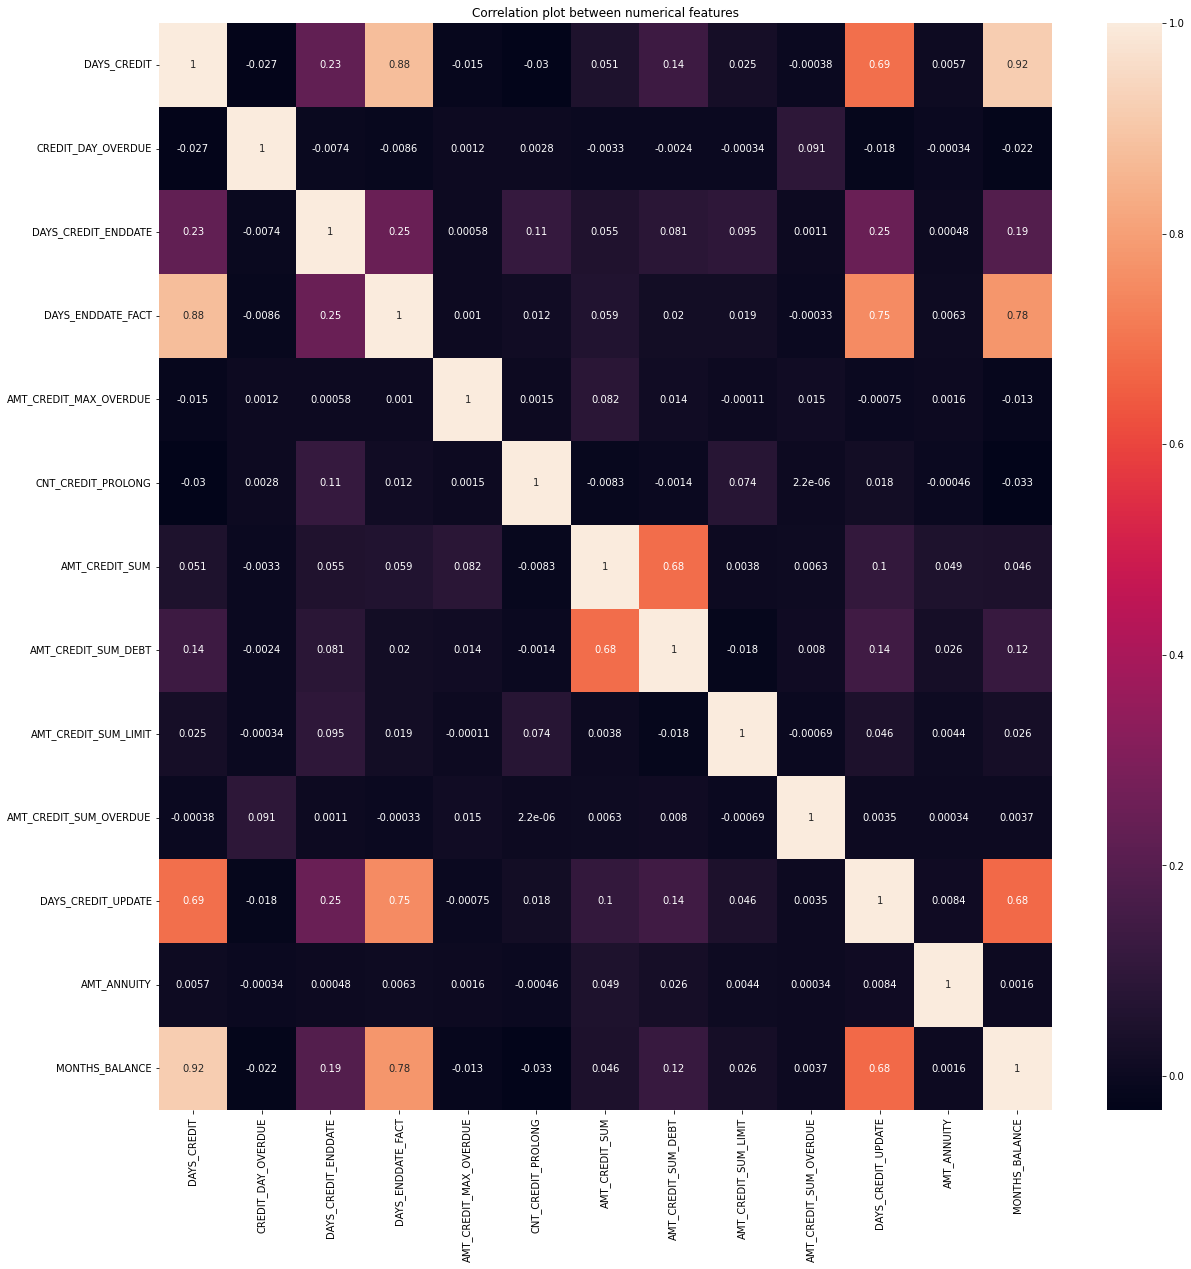

In [40]:
bb_unique_df = bureau_balance_df.groupby('SK_ID_BUREAU').agg({'MONTHS_BALANCE':'mean'})
bureau_merge = pd.merge(bureau_df, bb_unique_df, how='left', on='SK_ID_BUREAU')
num_features_df = bureau_merge.select_dtypes(exclude='object')
corr = num_features_df.drop(['SK_ID_BUREAU', 'SK_ID_CURR'], axis=1).corr()
plt.figure(figsize = (20, 20))
corr_plot = sns.heatmap(corr, annot = True)
plt.title("Correlation plot between numerical features")

Comment: High correlation exists between DAYS_CREDIT and DAYS_ENDDATE_FACT, DAYS_CREDIT and MONTHS_BALANCE

## 3. Previous application

 ### 3.1 Overview of the data

In [41]:
previous_application = pd.read_csv("../input/home-credit-default-risk/previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [43]:
check_missing_data(previous_application)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


Let's drop RATE_INTEREST_PRIVILEGED and RATE_INTEREST_PRIMARY because almost all of them is null

In [44]:
previous_application = previous_application.drop(["RATE_INTEREST_PRIVILEGED", "RATE_INTEREST_PRIMARY"], axis = 1)

In [45]:
print(f"duplicated rows in previous_application: {previous_application.duplicated().sum()}")

duplicated rows in previous_application: 0


In [46]:
previous_application.describe(include = np.number)

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [47]:
gr_by_status = previous_application.groupby("NAME_CONTRACT_STATUS")
mean_amount_status = gr_by_status.mean()[["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]]

<AxesSubplot:>

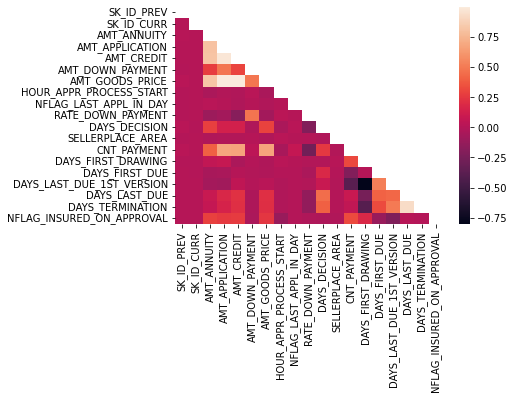

In [48]:
mask = np.triu(np.ones_like(previous_application.corr()))
sns.heatmap(previous_application.corr(), mask = mask)

In [49]:
high_corr = find_high_corr_pair(previous_application)
print(high_corr)

[('AMT_CREDIT', 'AMT_APPLICATION'), ('AMT_GOODS_PRICE', 'AMT_APPLICATION'), ('AMT_GOODS_PRICE', 'AMT_CREDIT'), ('DAYS_TERMINATION', 'DAYS_LAST_DUE')]


In [50]:
# drop one features in each pair
to_drop = ["AMT_APPLICATION", 'DAYS_LAST_DUE', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
previous_application.drop(to_drop, axis = 1, inplace = True)

In [51]:
# recheck
high_corr = find_high_corr_pair(previous_application)
print(high_corr)

[]


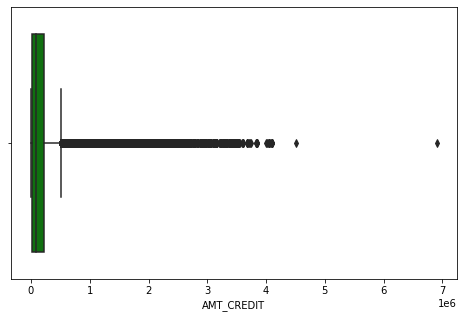

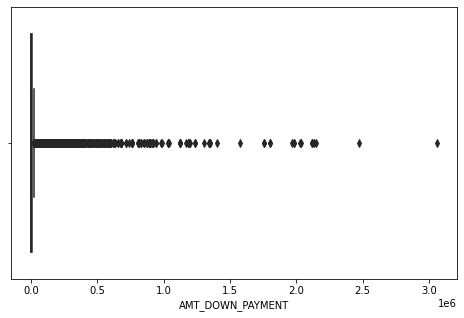

In [52]:
for i in ["AMT_CREDIT", "AMT_DOWN_PAYMENT"]:
    plot_numeric_dist_boxplot(previous_application, i)

We can see all the values for the amount columns have outliers, however, the case that price of a good or the amount of credit is exceptionally high is possible and may not be due to error in data entry, therefore, we cannot drop these values. Instead, we can transform these columns to log scale to make it more normally distributed

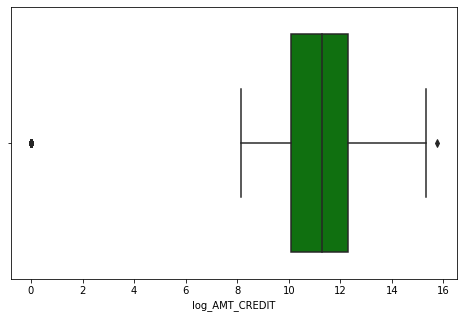

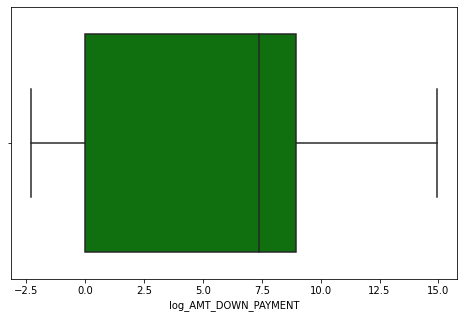

In [53]:
for i in ["AMT_CREDIT", "AMT_DOWN_PAYMENT"]:
    previous_application[i] = np.log1p(previous_application[i])
    previous_application.rename(columns={i: "log_" + i}, inplace = True)
    plot_numeric_dist_boxplot(previous_application, "log_" + i)


### 3.2 Exploring previous application

In [54]:
previous_application.filter(regex = "AMT_")

,log_AMT_CREDIT,log_AMT_DOWN_PAYMENT
0,9.749520,0.000000
1,13.429366,NaN
2,11.823681,NaN
3,13.062170,NaN
4,12.909309,NaN
...,...,...
1670209,12.648837,0.000000
1670210,11.071198,10.283669
1670211,11.537857,9.261651
1670212,12.164631,NaN


In [55]:
mean_amount_status

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE
NAME_CONTRACT_STATUS,,,,,
Approved,14720.350105,180567.000949,202564.182131,6862.640909,188348.698834
Canceled,30289.763892,22730.011481,24187.057127,31181.777216,668893.339078
Refused,20498.160274,331760.510938,371689.841222,7103.541914,380452.993018
Unused offer,10145.798635,69760.732970,69783.990800,1.078207,69773.929734


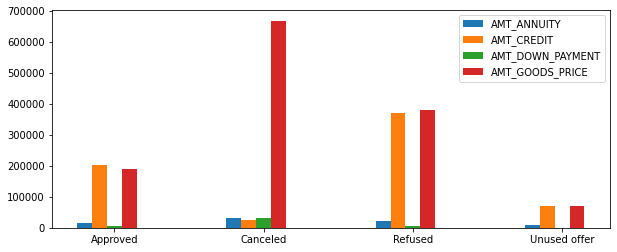

In [56]:
fig, ax = plt.subplots(figsize = (10, 4))
x = mean_amount_status.index
x_axis = np.arange(len(mean_amount_status.index))
y = ["AMT_ANNUITY", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]
for i in range(len(y)):
    ax.bar(x_axis -0.2 + (i*0.1), mean_amount_status[y[i]], width=0.1, label = y[i])
plt.xticks(x_axis, x)
plt.legend()

For refused and canceled applications, client asked for high goods price. Canceled previous applications also have high credit amount


Text(0.5, 1.0, 'Percentage of status from previous applicants')

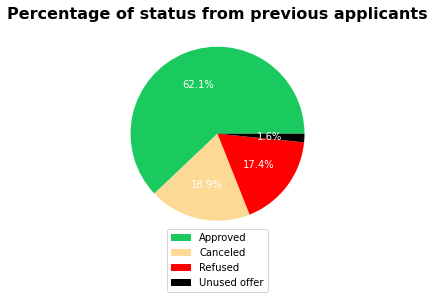

In [57]:
# Contract status distribution in previously filed application
fig, ax = plt.subplots(figsize = (10,4))
perc_status = previous_application["NAME_CONTRACT_STATUS"].value_counts(normalize = True)
ax.pie(perc_status.values, labels = perc_status.index, colors = ["#1bca5f", "#fcd994", "red", "black"], autopct='%1.1f%%', textprops=dict(color="w"))
ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.25))
ax.set_title("Percentage of status from previous applicants", size = 16, weight = "bold")

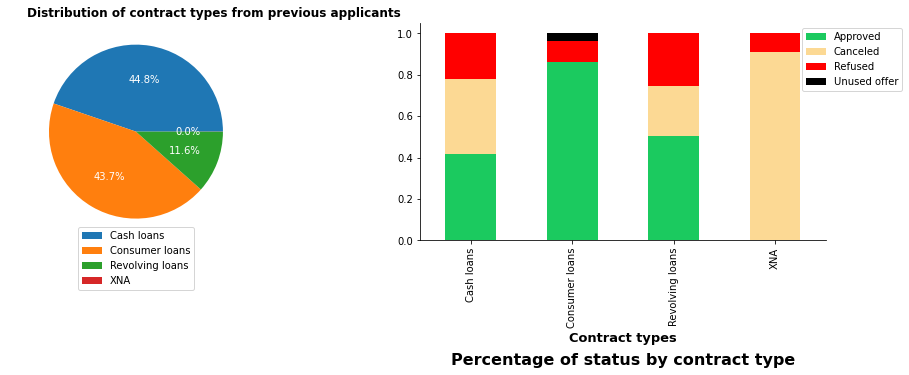

In [58]:
# Do different contract type have different status distribution
fig, (ax1, ax) = plt.subplots(ncols = 2, figsize = (16, 4))
perc_type = previous_application["NAME_CONTRACT_TYPE"].value_counts(normalize = True)
ax1.pie(perc_type.values, labels = perc_type.index, autopct='%1.1f%%', textprops=dict(color="w"))
ax1.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.25))
ax1.set_title("Distribution of contract types from previous applicants", size = 12, weight = "bold", loc = "left")
gr_by_type = previous_application.groupby("NAME_CONTRACT_TYPE")
perc_status_by_type = gr_by_type["NAME_CONTRACT_STATUS"].apply(lambda x:pd.value_counts(x, normalize = True))
temp = pd.DataFrame(perc_status_by_type).unstack()
temp.plot(kind = "bar", ax= ax, stacked = True, color = ["#1bca5f", "#fcd994", "red", "black"])
ax.legend(["Approved", "Canceled", "Refused", "Unused offer"],loc = "upper right", bbox_to_anchor=(1.2, 1))
ax.set_title("Percentage of status by contract type", size = 16, weight = "bold", y = -0.6)
ax.set_xlabel("Contract types", size = 13, weight = "bold")
delete_spine2(ax)

Text(0, 0.5, 'Number of applications')

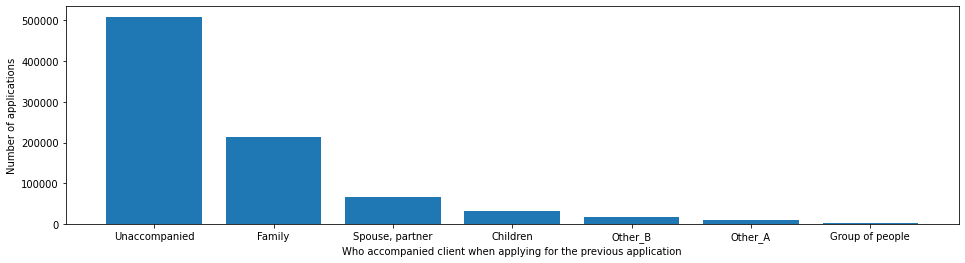

In [59]:
# Distribution of suite
fig, ax = plt.subplots(figsize = (16, 4))
count_suite = previous_application["NAME_TYPE_SUITE"].value_counts()
ax.bar(count_suite.index, count_suite.values)
ax.set_xlabel("Who accompanied client when applying for the previous application")
ax.set_ylabel("Number of applications")

Text(0.5, 0, 'Name of industry')

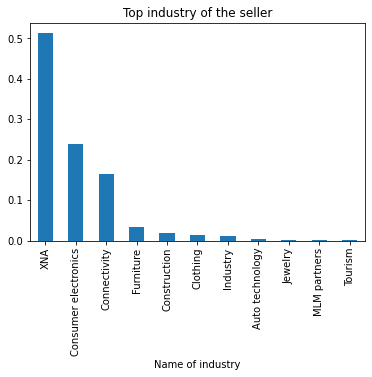

In [60]:
# Distribution of seller's industry
ax = previous_application["NAME_SELLER_INDUSTRY"].value_counts(normalize = True).plot(kind = "bar")
ax.set_title("Top industry of the seller")
ax.set_xlabel("Name of industry")

Text(0, 0.5, 'Number of applications')

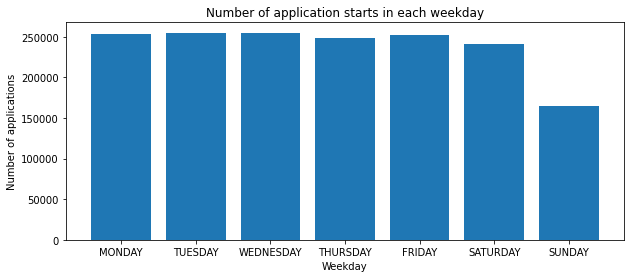

In [61]:
# Number of applications by time and hours
previous_application['WEEKDAY_APPR_PROCESS_START'] = pd.Categorical(previous_application['WEEKDAY_APPR_PROCESS_START'], ["MONDAY", "TUESDAY", "WEDNESDAY", "THURSDAY", "FRIDAY","SATURDAY", "SUNDAY"])
count_wd = previous_application['WEEKDAY_APPR_PROCESS_START'].value_counts().sort_index()
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(count_wd.index, count_wd.values)
ax.set_xlabel("Weekday")
ax.set_title("Number of application starts in each weekday")
ax.set_ylabel("Number of applications")

<BarContainer object of 1 artists>

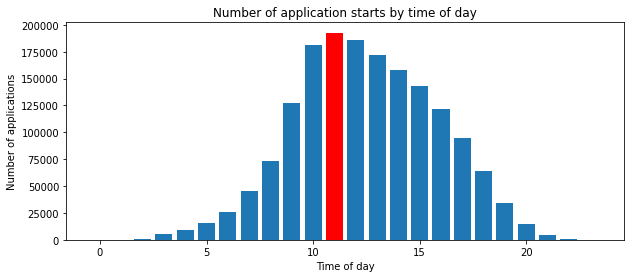

In [62]:
count_h = previous_application["HOUR_APPR_PROCESS_START"].value_counts().sort_index()
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(count_h.index, count_h.values)
ax.set_xlabel("Time of day")
ax.set_title("Number of application starts by time of day")
ax.set_ylabel("Number of applications")
ax.bar(count_h.index[11], count_h.values[11], color = "red")

In [63]:
for i in ["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_TERMINATION"]:
    temp = previous_application[previous_application[i]> 0][i]
    print(temp.unique(), len(temp))

[365243.] 934444
[365243.] 40645
[365243.] 225913


Because in "DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_TERMINATION" columns the only positive values is 365243 (in the future), we can ignore these values

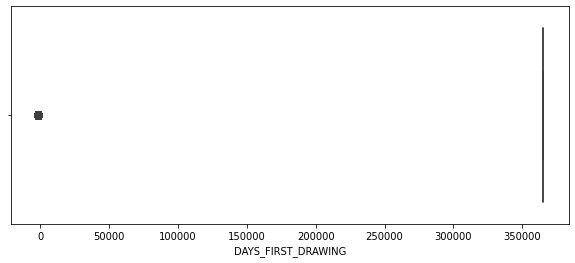

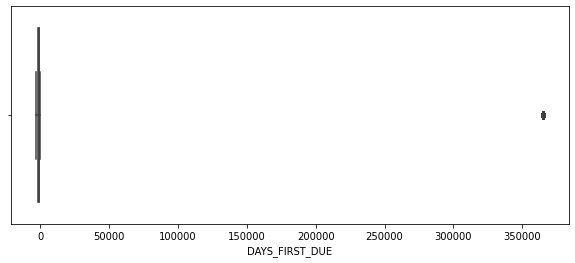

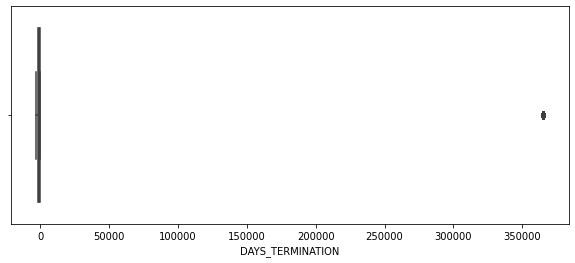

In [64]:
for i in ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_TERMINATION"]:
    fig, ax = plt.subplots(figsize = (10, 4))
    sns.boxplot(previous_application[i])

In [65]:
perc_outliers_DAYS_FIRST_DRAWING = len(previous_application.loc[previous_application["DAYS_FIRST_DRAWING"] > 0]) / len(previous_application)
perc_outliers_DAYS_FIRST_DUE = len(previous_application.loc[previous_application["DAYS_FIRST_DUE"] > 0]) / len(previous_application)
perc_outliers_DAYS_TERMINATION = len(previous_application.loc[previous_application["DAYS_TERMINATION"] > 0]) / len(previous_application)
perc_outliers_DAYS_LAST_DUE_1ST_VERSION = len(previous_application.loc[previous_application["DAYS_LAST_DUE_1ST_VERSION"] > 0]) / len(previous_application)
print(f"ratio of 365243 values in DAYS_FIRST_DRAWING: {perc_outliers_DAYS_FIRST_DRAWING}")
print(f"ratio of 365243 values in DAYS_FIRST_DUE: {perc_outliers_DAYS_FIRST_DUE}")

ratio of 365243 values in DAYS_FIRST_DRAWING: 0.5594756121071911
ratio of 365243 values in DAYS_FIRST_DUE: 0.02433520494978488


We can only drop these values for DAYS_FIRST_DUE and DAYS_TERMINATION

In [66]:
previous_application["DAYS_FIRST_DUE"].loc[previous_application["DAYS_FIRST_DUE"] > 0] = np.nan
previous_application["DAYS_TERMINATION"].loc[previous_application["DAYS_TERMINATION"] > 0] = np.nan

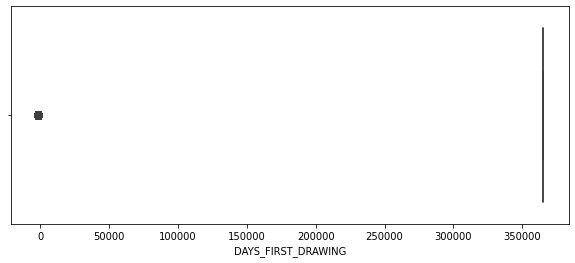

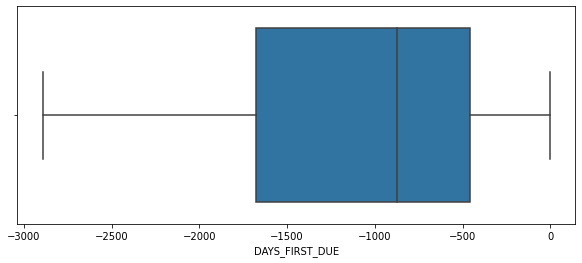

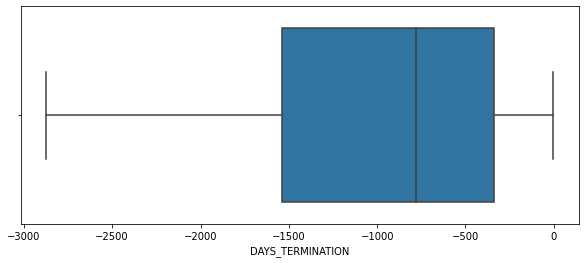

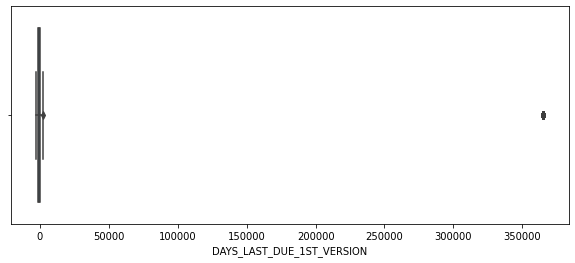

In [67]:
for i in ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_TERMINATION", "DAYS_LAST_DUE_1ST_VERSION"]:
    fig, ax = plt.subplots(figsize = (10, 4))
    sns.boxplot(previous_application[i])

In [68]:
def plot_numeric_dist2(table, column):

    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {column}")
    ax = sns.distplot(table[table[column] < 0][column])

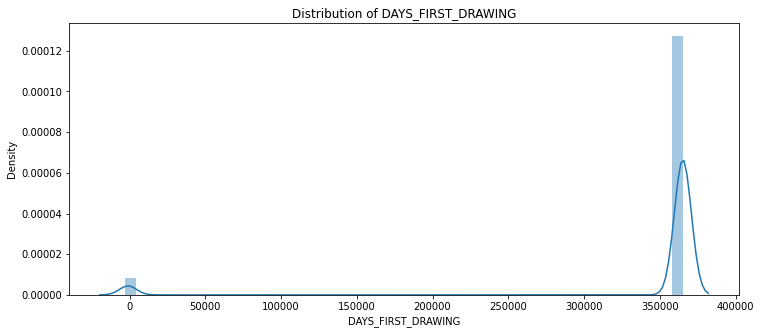

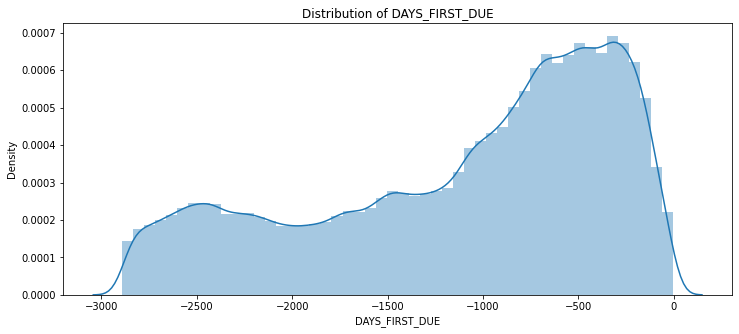

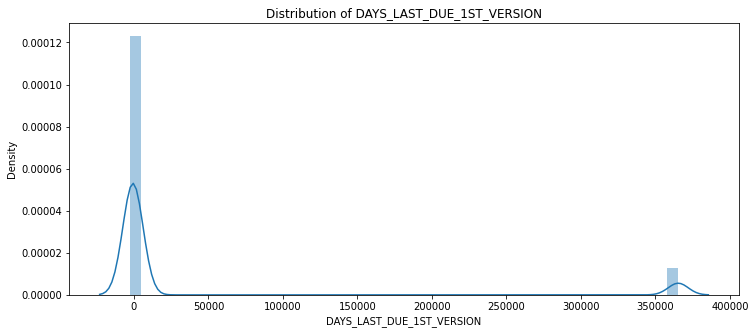

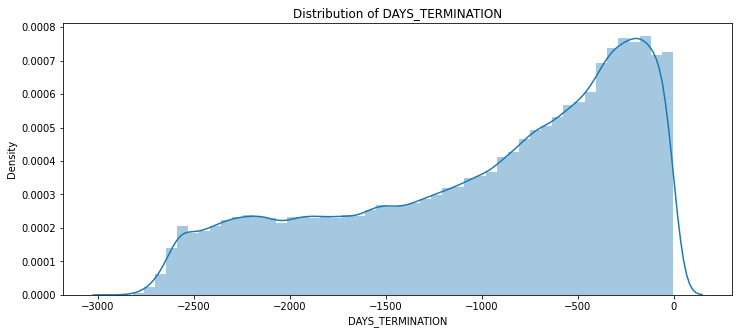

In [69]:
for i in ["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_TERMINATION"]:
    plot_numeric_dist(previous_application, i)

<AxesSubplot:>

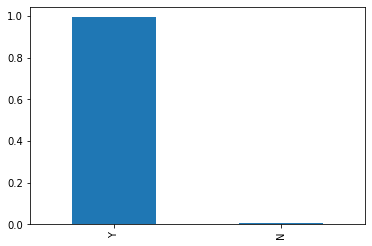

In [70]:
previous_application['FLAG_LAST_APPL_PER_CONTRACT'].value_counts(normalize = True).plot(kind = "bar")

<AxesSubplot:>

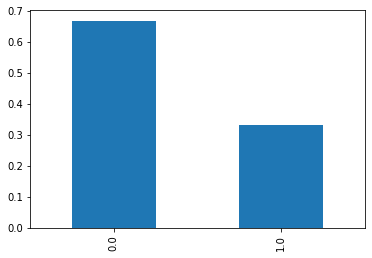

In [71]:
previous_application['NFLAG_INSURED_ON_APPROVAL'].value_counts(normalize = True).plot(kind = "bar")

<AxesSubplot:>

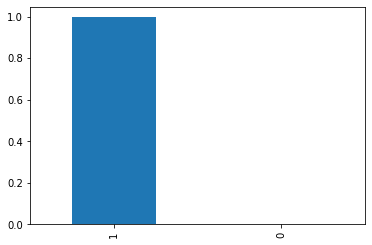

In [72]:
previous_application["NFLAG_LAST_APPL_IN_DAY"].value_counts(normalize = True).plot(kind = "bar")

Because in almost all rows in this data, NFLAG_LAST_APPL_IN_DAY is 1 thus and FLAG_LAST_APPL_PER_CONTRACT is 0 this features doesn't yield much insight, we can drop this feature

In [73]:
previous_application.drop(["NFLAG_LAST_APPL_IN_DAY", 'FLAG_LAST_APPL_PER_CONTRACT'], axis = 1, inplace = True)


## 4. Credit card balance

### 4.1 Overview of data

In [74]:
credit_card_balance = pd.read_csv("../input/home-credit-default-risk/credit_card_balance.csv")

In [75]:
credit_card_balance.describe(include = np.number)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [76]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [77]:
check_missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208


In [78]:
high_corr = find_high_corr_pair(credit_card_balance)
high_corr

[('AMT_PAYMENT_TOTAL_CURRENT', 'AMT_PAYMENT_CURRENT'),
 ('AMT_RECEIVABLE_PRINCIPAL', 'AMT_BALANCE'),
 ('AMT_RECIVABLE', 'AMT_BALANCE'),
 ('AMT_RECIVABLE', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_BALANCE'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_RECIVABLE'),
 ('CNT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_CURRENT')]

In [79]:
to_drop = ["AMT_DRAWINGS_ATM_CURRENT", 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECIVABLE', 'CNT_DRAWINGS_POS_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'AMT_RECEIVABLE_PRINCIPAL']
credit_card_balance.drop(to_drop, axis = 1, inplace = True)

### 4.2 Explore data

Text(0.5, 1.0, 'Count contracts by status')

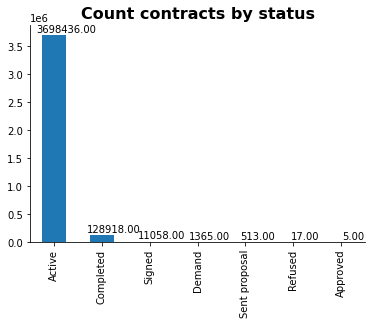

In [80]:
plots = credit_card_balance["NAME_CONTRACT_STATUS"].value_counts().plot(kind = "bar")
for bar in plots.patches:
    plt.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() + 0.01 / 2,
                        bar.get_height() + 100000), ha='center', va='center')
delete_spine2(plots)
plots.set_title("Count contracts by status", size = 16, weight = "bold")

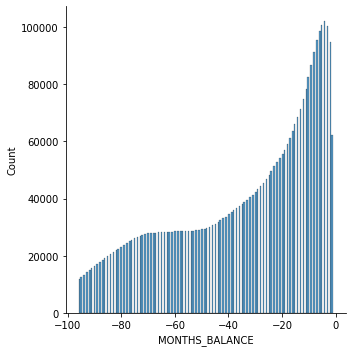

In [81]:
sns.displot(credit_card_balance["MONTHS_BALANCE"])

#### Exploring numeric features

In [82]:
numeric_only = credit_card_balance.select_dtypes(include=np.number)
numeric_only.drop([	"SK_ID_PREV", "SK_ID_CURR"], axis = 1, inplace = True)

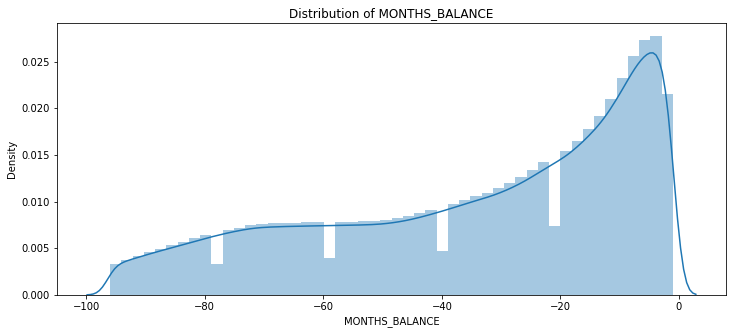

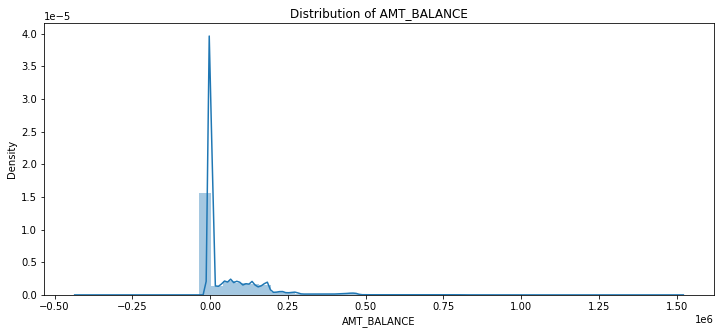

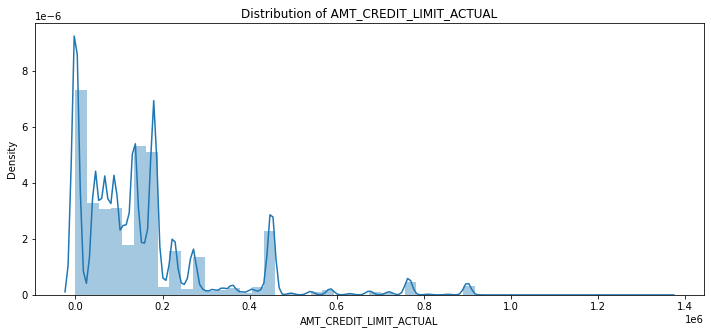

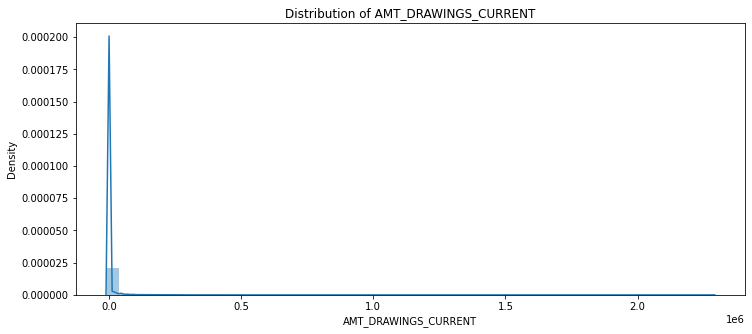

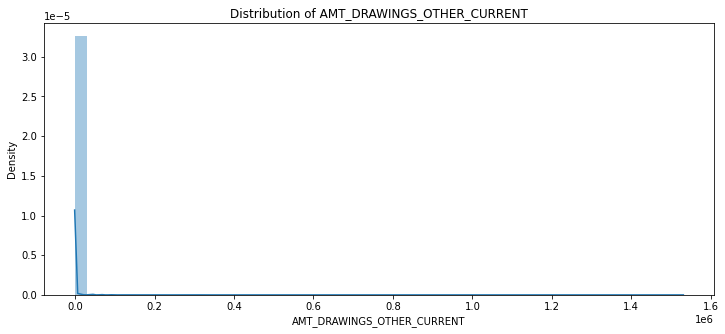

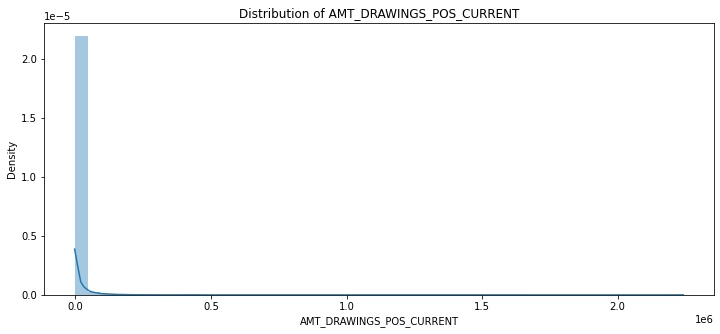

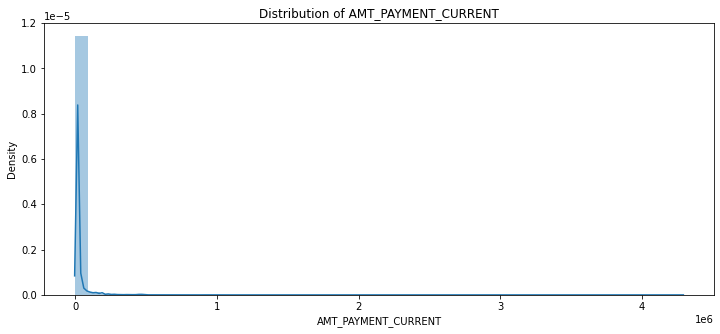

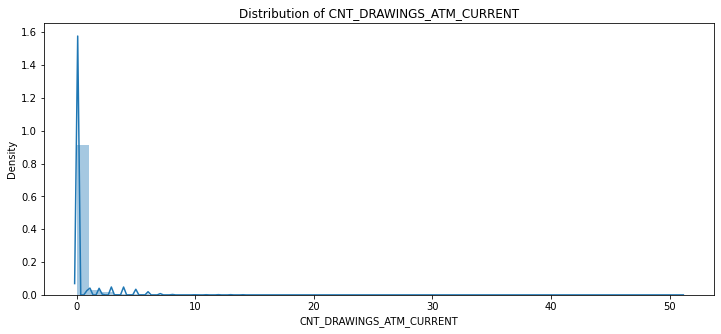

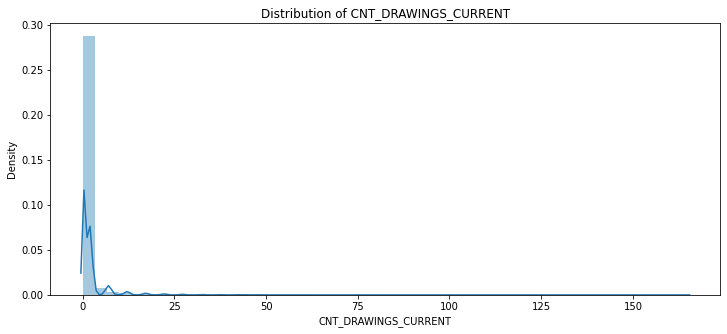

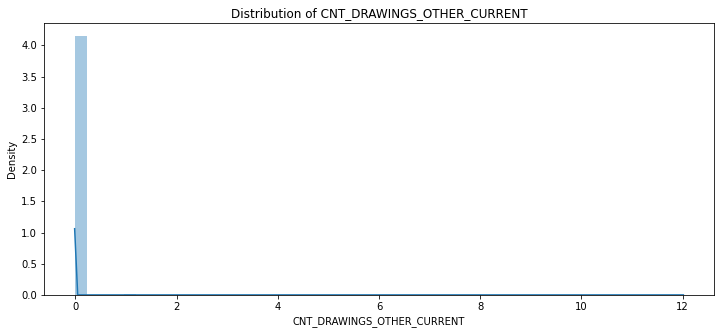

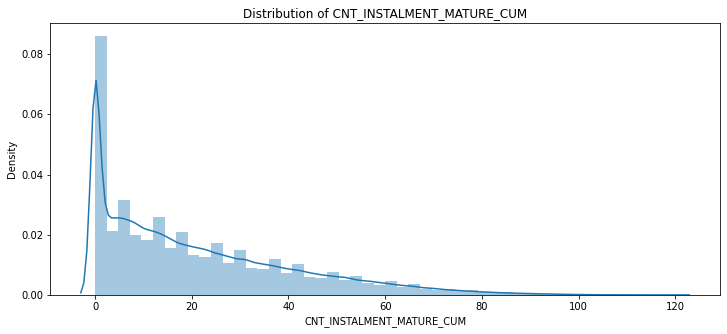

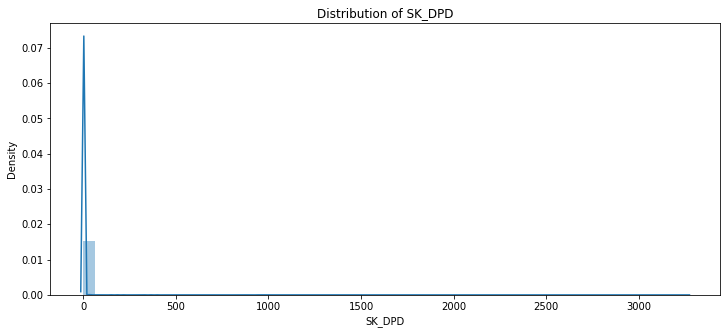

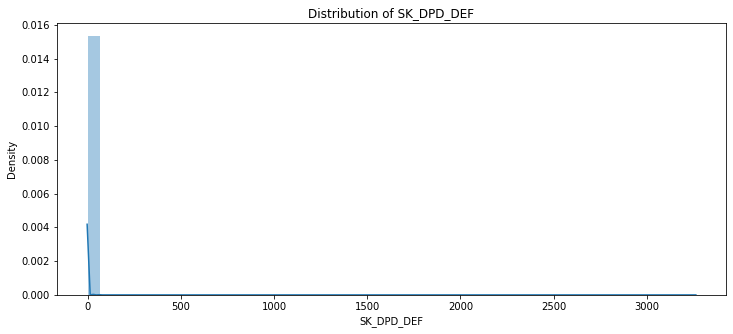

In [83]:
for i in numeric_only.columns:
    plot_numeric_dist(numeric_only, i)

## 5. POS_CASH

### 5.1 Overview of data

In [84]:
pos_cash=pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')


In [85]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [86]:
pos_cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [87]:
check_missing_data(pos_cash)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675


In [88]:
print(f"duplicated rows in pos_cash: {pos_cash.duplicated().sum()}")

duplicated rows in pos_cash: 0


In [89]:
check_missing_data(pos_cash)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675


In [90]:
pos_cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


### 5.2 Explore data

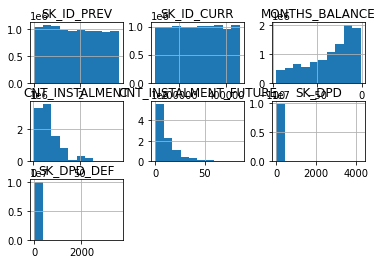

In [91]:
pos_cash.hist()
plt.show()

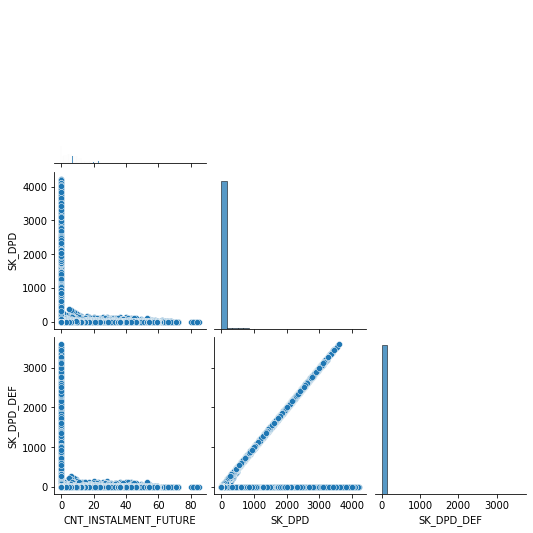

In [92]:
sns.pairplot(pos_cash.iloc[:,4:8], corner=True)

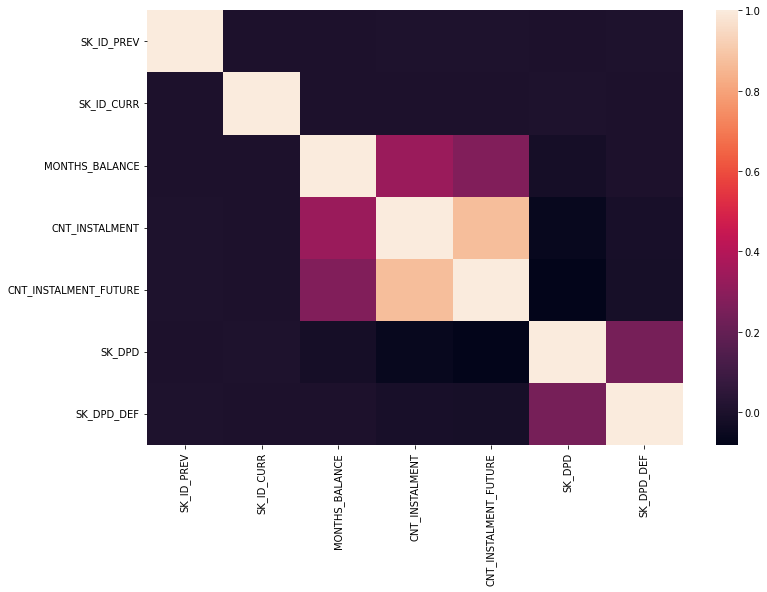

In [93]:
plt.figure(figsize=(12,8))
sns.heatmap(pos_cash.corr())

plt.show()

In [94]:
find_high_corr_pair(pos_cash)

[]

## 6. Installment payment

6.1 Overview of data

In [95]:
install_pay=pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')

In [96]:
install_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [97]:
install_pay.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [98]:

print(f"duplicated rows in install_pay: {install_pay.duplicated().sum()}")

duplicated rows in install_pay: 0


In [99]:
check_missing_data(install_pay)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352


That the average AMT_INSTALLMENTS (the prescribed installment amount on this installment is) smaller than AMT_PAYMENTS (the amount client actually paid on this installment) suggests: Some loans are not repayed on time

array([[<AxesSubplot:title={'center':'NUM_INSTALMENT_VERSION'}>,
        <AxesSubplot:title={'center':'NUM_INSTALMENT_NUMBER'}>],
       [<AxesSubplot:title={'center':'DAYS_INSTALMENT'}>,
        <AxesSubplot:title={'center':'DAYS_ENTRY_PAYMENT'}>]],
      dtype=object)

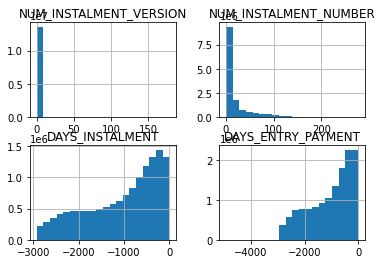

In [100]:
install_pay.iloc[:,2:6].hist(bins=20)

The histogram of prescribed installment day and actually paid day also suggests late payment of the customer

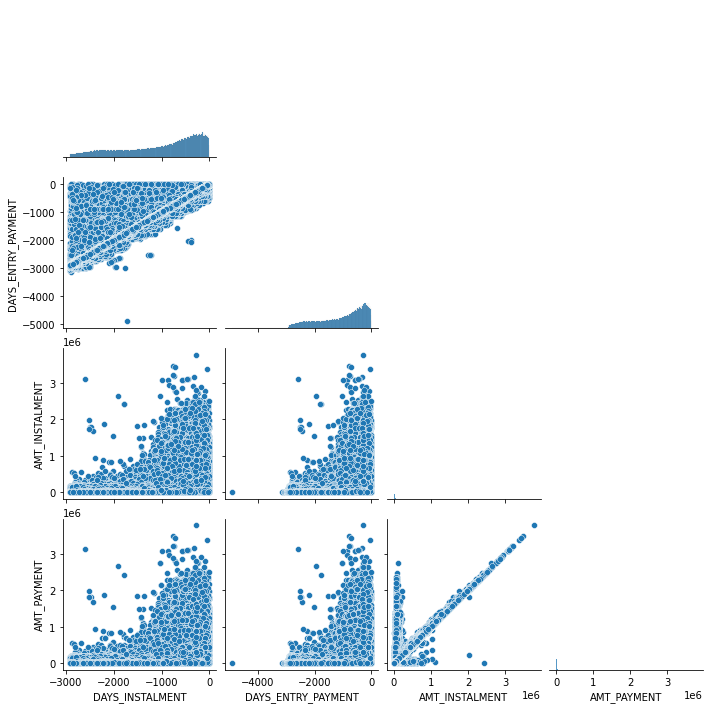

In [101]:
sns.pairplot(install_pay.iloc[:,4:8], corner=True)

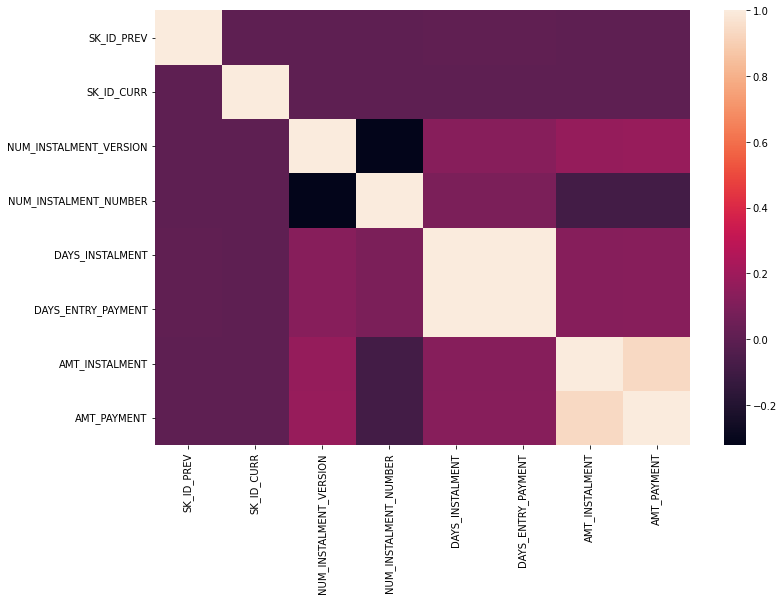

In [102]:
plt.figure(figsize=(12,8))
sns.heatmap(install_pay.corr())

plt.show()

# II. Merging dataframes

## 1. Merge Bureau Balance and Bureau

In [103]:
bureau_merge = pd.merge(bureau_df, bb_unique_df, how='left', on='SK_ID_BUREAU')
bureau_merge.shape

(1716428, 18)

Text(0.5, 1.0, 'Correlation plot between numerical features')

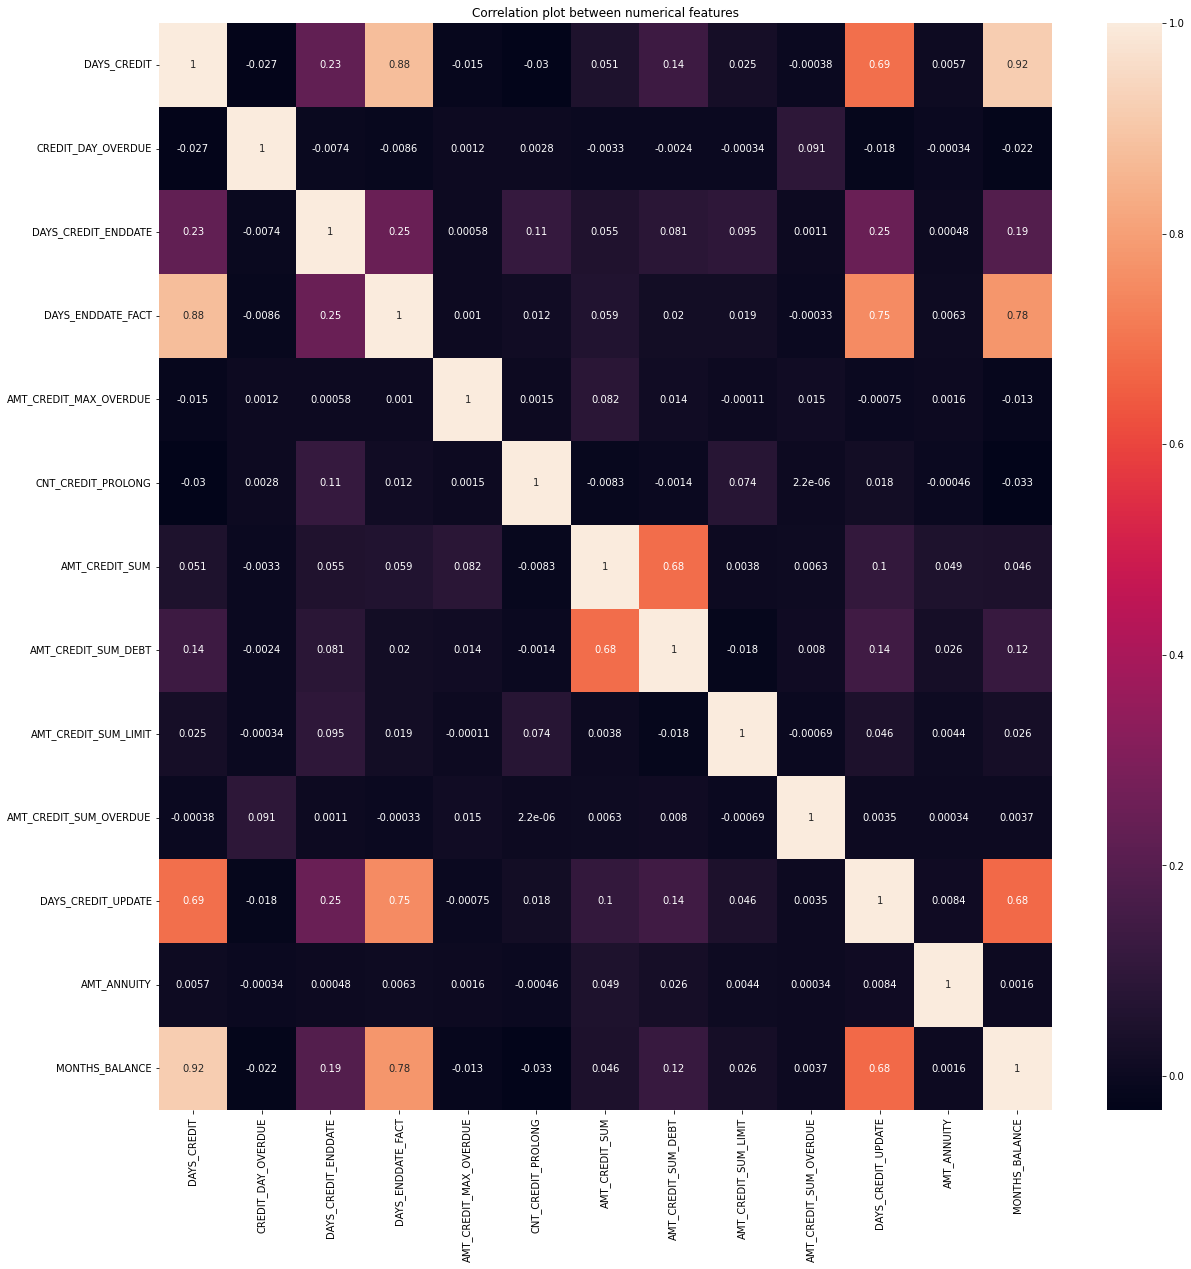

In [104]:
num_features_df = bureau_merge.select_dtypes(exclude='object')
corr = num_features_df.drop(['SK_ID_BUREAU', 'SK_ID_CURR'], axis=1).corr()
plt.figure(figsize = (20, 20))
corr_plot = sns.heatmap(corr, annot = True)
plt.title("Correlation plot between numerical features")

In [105]:
print(f"percentage of each value in CREDIT_DAY_OVERDUE:\n {bureau_df['CREDIT_DAY_OVERDUE'].value_counts(normalize=True) * 100}")
print(f"percentage of each value in CNT_CREDIT_PROLONG:\n {bureau_df['CNT_CREDIT_PROLONG'].value_counts(normalize=True) * 100}")
print(f"percentage of each value in AMT_CREDIT_SUM_OVERDUE:\n {bureau_df[ 'AMT_CREDIT_SUM_OVERDUE'].value_counts(normalize=True) * 100}")
print(f"percentage of each value in CREDIT_CURRENCY:\n {bureau_df[ 'CREDIT_CURRENCY'].value_counts(normalize=True) * 100}")

percentage of each value in CREDIT_DAY_OVERDUE:
 0       99.754315
30       0.018119
60       0.007341
8        0.006001
13       0.006001
          ...    
1445     0.000058
278      0.000058
707      0.000058
2193     0.000058
1931     0.000058
Name: CREDIT_DAY_OVERDUE, Length: 942, dtype: float64
percentage of each value in CNT_CREDIT_PROLONG:
 0    99.469014
1     0.443945
2     0.071194
3     0.011128
4     0.003146
5     0.001223
9     0.000117
6     0.000117
8     0.000058
7     0.000058
Name: CNT_CREDIT_PROLONG, dtype: float64
percentage of each value in AMT_CREDIT_SUM_OVERDUE:
 0.000       99.757753
4.500        0.017536
9.000        0.006234
13.500       0.004719
18.000       0.004195
              ...    
323.010      0.000058
88.695       0.000058
142.830      0.000058
5069.070     0.000058
352.620      0.000058
Name: AMT_CREDIT_SUM_OVERDUE, Length: 1616, dtype: float64
percentage of each value in CREDIT_CURRENCY:
 currency 1    99.917969
currency 2     0.071311
currency 3 

Comment:
* CREDIT_DAY_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM_OVERDUE: the percentage of 0 value more than 99% -> drop these columns
* Almost values in CREDIT_CURRENCY column is currency 1 (nearly 100%) -> drop column

In [106]:
bureau_clean_df = bureau_df.drop(['CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_CURRENCY'], axis = 1)
bureau_clean_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,-497,-153.0,-153.0,NaN,91323.00,0.0,NaN,Consumer credit,-131,NaN
1,215354,5714463,Active,-208,1075.0,NaN,NaN,225000.00,171342.0,NaN,Credit card,-20,NaN
2,215354,5714464,Active,-203,528.0,NaN,NaN,464323.50,NaN,NaN,Consumer credit,-16,NaN
3,215354,5714465,Active,-203,NaN,NaN,NaN,90000.00,NaN,NaN,Credit card,-16,NaN
4,215354,5714466,Active,-629,1197.0,NaN,77674.5,2700000.00,NaN,NaN,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,-44,-30.0,NaN,0.0,11250.00,11250.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,-2648,-2433.0,-2493.0,5476.5,38130.84,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,-1809,-1628.0,-970.0,NaN,15570.00,NaN,NaN,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,-1878,-1513.0,-1513.0,NaN,36000.00,0.0,0.0,Consumer credit,-1508,NaN


From the correlation matrix, we can see that:

* high correlation exists between DAYS_CREDIT and DAYS_ENDDATE_FACT > 0.8% -> drop these 2 columns
* high correlation exists between DAYS_CREDIT and MONTHS_BALANCE > 0.9% -> drop these 2 columns

In [107]:
bureau_clean_df = bureau_clean_df.drop(['DAYS_CREDIT', 'DAYS_ENDDATE_FACT'], axis = 1)
bureau_clean_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,-153.0,NaN,91323.0,0.0,NaN,Consumer credit,-131,NaN
1,215354,5714463,Active,1075.0,NaN,225000.0,171342.0,NaN,Credit card,-20,NaN
2,215354,5714464,Active,528.0,NaN,464323.5,NaN,NaN,Consumer credit,-16,NaN
3,215354,5714465,Active,NaN,NaN,90000.0,NaN,NaN,Credit card,-16,NaN
4,215354,5714466,Active,1197.0,77674.5,2700000.0,NaN,NaN,Consumer credit,-21,NaN


Add feature
* DEBT OVER CREDIT RATIO The Ratio of Total Debt to Total Credit for each Customer. A High value may be a red flag indicative of potential default

In [108]:
grp1 = bureau_clean_df[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = bureau_clean_df[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

bureau_clean_df = bureau_clean_df.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
bureau_clean_df= bureau_clean_df.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2

bureau_clean_df['DEBT_OVER_CREDIT'] = bureau_clean_df['TOTAL_CUSTOMER_DEBT']/bureau_clean_df['TOTAL_CUSTOMER_CREDIT']


In [109]:
bureau_clean_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TOTAL_CUSTOMER_DEBT,TOTAL_CUSTOMER_CREDIT,DEBT_OVER_CREDIT
0,215354,5714462,Closed,-153.0,NaN,91323.00,0.0,NaN,Consumer credit,-131,NaN,284463.180,5973945.30,0.047617
1,215354,5714463,Active,1075.0,NaN,225000.00,171342.0,NaN,Credit card,-20,NaN,284463.180,5973945.30,0.047617
2,215354,5714464,Active,528.0,NaN,464323.50,NaN,NaN,Consumer credit,-16,NaN,284463.180,5973945.30,0.047617
3,215354,5714465,Active,NaN,NaN,90000.00,NaN,NaN,Credit card,-16,NaN,284463.180,5973945.30,0.047617
4,215354,5714466,Active,1197.0,77674.5,2700000.00,NaN,NaN,Consumer credit,-21,NaN,284463.180,5973945.30,0.047617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,-30.0,0.0,11250.00,11250.0,0.0,Microloan,-19,NaN,22500.000,131502.51,0.171099
1716424,100044,5057754,Closed,-2433.0,5476.5,38130.84,0.0,0.0,Consumer credit,-2493,NaN,1147764.600,2329694.46,0.492667
1716425,100044,5057762,Closed,-1628.0,NaN,15570.00,NaN,NaN,Consumer credit,-967,NaN,1147764.600,2329694.46,0.492667
1716426,246829,5057770,Closed,-1513.0,NaN,36000.00,0.0,0.0,Consumer credit,-1508,NaN,237417.525,1253731.50,0.189369


NUMBER OF PAST LOANS PER CUSTOMER

In [110]:
grp = bureau_clean_df[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns={'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
bureau_clean_df = bureau_clean_df.merge(grp, on = ['SK_ID_CURR'], how = 'left')

In [111]:
num_agg = {}
num_col = bureau_clean_df.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis = 1).select_dtypes(exclude='object').columns
for i in num_col:
    num_agg[i] = 'mean'
bureau_clean_df = bureau_clean_df.groupby('SK_ID_CURR', as_index=False).agg({**num_agg})
bureau_clean_df

,SK_ID_CURR,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TOTAL_CUSTOMER_DEBT,TOTAL_CUSTOMER_CREDIT,DEBT_OVER_CREDIT,BUREAU_LOAN_COUNT
0,100001,82.428571,NaN,2.076236e+05,85240.928571,0.00000,-93.142857,3545.357143,596686.500,1453365.000,0.410555,7.0
1,100002,-349.000000,1681.029,1.081319e+05,49156.200000,7997.14125,-499.875000,0.000000,245781.000,865055.565,0.284122,8.0
2,100003,-544.500000,0.000,2.543501e+05,0.000000,202500.00000,-816.000000,NaN,0.000,1017400.500,0.000000,4.0
3,100004,-488.500000,0.000,9.451890e+04,0.000000,0.00000,-532.000000,NaN,0.000,189037.800,0.000000,2.0
4,100005,439.333333,0.000,2.190420e+05,189469.500000,0.00000,-54.333333,1420.500000,568408.500,657126.000,0.864992,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-1232.333333,6147.000,2.841430e+05,16307.100000,0.00000,-1064.538462,NaN,163071.000,3693858.660,0.044147,13.0
305807,456250,1288.333333,0.000,1.028820e+06,744013.365000,19422.79500,-60.333333,154567.965000,2232040.095,3086459.550,0.723172,3.0
305808,456253,280.500000,NaN,9.900000e+05,448958.250000,0.00000,-253.250000,58369.500000,1795833.000,3960000.000,0.453493,4.0
305809,456254,-859.000000,NaN,4.500000e+04,0.000000,NaN,-401.000000,0.000000,0.000,45000.000,0.000000,1.0


## 2. Merge Bureau with Application Train

In [112]:
application_train.shape

(307511, 84)

In [113]:
bureau_clean_df.rename(columns={'AMT_ANNUITY': 'AMT_ANNUITY_Bureau'}, inplace=True)
app_train_merge = pd.merge(application_train,bureau_clean_df, how='left', on='SK_ID_CURR')
app_train_merge.shape

(307511, 95)

## 3.Merge credit card balance and installment payments

### 3.1 Summarizing credit_balance

In [114]:
credit_card_balance[credit_card_balance["SK_ID_PREV"] == 1000018][["CNT_INSTALMENT_MATURE_CUM", "CNT_DRAWINGS_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT", "MONTHS_BALANCE"]].sort_values("MONTHS_BALANCE")

,CNT_INSTALMENT_MATURE_CUM,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,MONTHS_BALANCE
1375415,0.0,15,0.0,0.0,-6
277653,1.0,2,0.0,0.0,-5
2559582,2.0,2,0.0,0.0,-4
2192275,3.0,14,0.0,0.0,-3
2159094,4.0,11,0.0,0.0,-2


Maximum of count values is the total number of paid installments, the highest number of drawings within each previous application

In [115]:
credit_card_balance_cnt = credit_card_balance.filter(regex = "CNT_")
credit_card_balance_cnt["SK_ID_PREV"] = credit_card_balance["SK_ID_PREV"]
credit_grouped_cnt = credit_card_balance_cnt.groupby("SK_ID_PREV")
credit_grouped_cnt_max = credit_grouped_cnt.max()
credit_grouped_cnt_max = credit_grouped_cnt_max.add_suffix("_max")
credit_grouped_cnt_max.head()

,CNT_DRAWINGS_ATM_CURRENT_max,CNT_DRAWINGS_CURRENT_max,CNT_DRAWINGS_OTHER_CURRENT_max,CNT_INSTALMENT_MATURE_CUM_max
SK_ID_PREV,,,,
1000018,3.0,15,0.0,4.0
1000030,1.0,14,0.0,5.0
1000031,2.0,4,0.0,10.0
1000035,NaN,0,NaN,0.0
1000077,NaN,0,NaN,0.0


In [116]:
credit_card_balance_amt = credit_card_balance.filter(regex = "AMT_")
credit_card_balance_amt["SK_ID_PREV"] = credit_card_balance["SK_ID_PREV"]
credit_grouped_amt = credit_card_balance_amt.groupby("SK_ID_PREV")
credit_grouped_amt_mean = credit_grouped_amt.mean()
credit_grouped_amt_mean = credit_grouped_amt_mean.add_suffix("_avg")
credit_grouped_amt_mean.head()

,AMT_BALANCE_avg,AMT_CREDIT_LIMIT_ACTUAL_avg,AMT_DRAWINGS_CURRENT_avg,AMT_DRAWINGS_OTHER_CURRENT_avg,AMT_DRAWINGS_POS_CURRENT_avg,AMT_PAYMENT_CURRENT_avg
SK_ID_PREV,,,,,,
1000018,74946.285000,81000.000000,29478.996000,0.0,24078.996000,5541.750000
1000030,55991.064375,81562.500000,17257.438125,0.0,19079.929286,6188.631429
1000031,52394.439375,149625.000000,28959.615000,0.0,23527.218462,29543.257500
1000035,0.000000,225000.000000,0.000000,NaN,NaN,NaN
1000077,0.000000,94090.909091,0.000000,NaN,NaN,NaN


Because we contract status only show the stages of each transactions in the past applications, it doesn't concern the current application so we leave this feature out

In [117]:
credit_card_balance_sk = credit_card_balance.filter(regex = "SK_")
credit_card_balance_sk["SK_ID_PREV"] = credit_card_balance["SK_ID_PREV"]
credit_grouped_sk = credit_card_balance_sk.groupby("SK_ID_PREV")
credit_grouped_sk_mean = credit_grouped_sk.mean()
credit_grouped_sk_mean = credit_grouped_sk_mean.rename({"SK_DPD": "SK_DPD_avg", "SK_DPD_DEF": "SK_DPD_DEF_avg"}, axis = 1)

In [118]:
summarized_credit_balance = credit_grouped_sk_mean.merge(credit_grouped_amt_mean, on  = "SK_ID_PREV")
summarized_credit_balance = summarized_credit_balance.merge(credit_grouped_cnt_max, on = "SK_ID_PREV")
summarized_credit_balance

,SK_ID_CURR,SK_DPD_avg,SK_DPD_DEF_avg,AMT_BALANCE_avg,AMT_CREDIT_LIMIT_ACTUAL_avg,AMT_DRAWINGS_CURRENT_avg,AMT_DRAWINGS_OTHER_CURRENT_avg,AMT_DRAWINGS_POS_CURRENT_avg,AMT_PAYMENT_CURRENT_avg,CNT_DRAWINGS_ATM_CURRENT_max,CNT_DRAWINGS_CURRENT_max,CNT_DRAWINGS_OTHER_CURRENT_max,CNT_INSTALMENT_MATURE_CUM_max
SK_ID_PREV,,,,,,,,,,,,,
1000018,394447.0,0.000000,0.000000,74946.285000,81000.000000,29478.996000,0.0,24078.996000,5541.750000,3.0,15,0.0,4.0
1000030,361282.0,0.000000,0.000000,55991.064375,81562.500000,17257.438125,0.0,19079.929286,6188.631429,1.0,14,0.0,5.0
1000031,131335.0,0.000000,0.000000,52394.439375,149625.000000,28959.615000,0.0,23527.218462,29543.257500,2.0,4,0.0,10.0
1000035,436351.0,0.000000,0.000000,0.000000,225000.000000,0.000000,NaN,NaN,NaN,NaN,0,NaN,0.0
1000077,181153.0,0.000000,0.000000,0.000000,94090.909091,0.000000,NaN,NaN,NaN,NaN,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843476,197090.0,15.031579,3.473684,37937.812263,161526.315789,947.368421,0.0,0.000000,3467.420053,2.0,2,0.0,41.0
2843477,168439.0,0.000000,0.000000,1663.076647,15882.352941,688.235294,0.0,0.000000,955.265294,6.0,6,0.0,4.0
2843478,424526.0,0.000000,0.000000,5111.405000,21000.000000,1000.000000,0.0,0.000000,1355.795000,3.0,3,0.0,10.0


### 3.2 Summarizing installments_payments

In [119]:
installments_payments_grouped = install_pay.groupby("SK_ID_PREV")

Adding balance (AMT_PAYMENT - AMT_INSTALMENT) to see how much the applicants not paying enough and default (True if the balance is negative, False otherwise)

In [120]:
def check_late_payment(arr):
    if arr < 0:
        return 1
    elif arr >= 0:
        return 0
    else:
        return np.nan

In [121]:
# days late is the day the installment is supposed to be paid (relative to current payment) minus the day the payment was made (relative to current payment)
install_pay["DAYS_LATE"] = abs(install_pay["DAYS_INSTALMENT"]) - abs(install_pay["DAYS_ENTRY_PAYMENT"])
install_pay["late_payment"] = install_pay["DAYS_LATE"].apply(check_late_payment)
install_pay["balance"] = install_pay["AMT_PAYMENT"] - install_pay["AMT_INSTALMENT"]
install_pay["not_enough_payment"] = install_pay["balance"].apply(check_late_payment)

In [122]:
grouped_installments = install_pay.groupby("SK_ID_PREV")
total_not_enough_payment = grouped_installments["not_enough_payment"].sum()
total_late_payment = grouped_installments["late_payment"].sum()

In [123]:
installments_payments_grouped = install_pay.groupby("SK_ID_PREV")
installments_payments_mean = installments_payments_grouped.mean()
installments_payments_mean = installments_payments_mean.add_suffix("_mean")
installments_payments_mean.rename({"SK_ID_CURR_mean": "SK_ID_CURR"}, inplace = True, axis = 1)
installments_payments_mean["CNT_late_payment"] = total_late_payment
installments_payments_mean["CNT_not_enough_payment"] = total_not_enough_payment
installments_payments_mean

,SK_ID_CURR,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_NUMBER_mean,DAYS_INSTALMENT_mean,DAYS_ENTRY_PAYMENT_mean,AMT_INSTALMENT_mean,AMT_PAYMENT_mean,DAYS_LATE_mean,late_payment_mean,balance_mean,not_enough_payment_mean,CNT_late_payment,CNT_not_enough_payment
SK_ID_PREV,,,,,,,,,,,,,
1000001,158271.0,1.500000,1.500000,-253.000000,-269.000000,34221.712500,34221.712500,-16.000000,1.000000,0.000000,0.000000,2.0,0.0
1000002,101962.0,1.250000,2.500000,-1555.000000,-1574.750000,9308.891250,9308.891250,-19.750000,1.000000,0.000000,0.000000,4.0,0.0
1000003,252457.0,1.000000,2.000000,-64.000000,-79.333333,4951.350000,4951.350000,-15.333333,1.000000,0.000000,0.000000,3.0,0.0
1000004,260094.0,1.142857,4.000000,-772.000000,-798.714286,4789.022143,4789.022143,-26.714286,1.000000,0.000000,0.000000,7.0,0.0
1000005,176456.0,1.000000,5.818182,-1543.454545,-1551.909091,14703.210000,13365.609545,-8.454545,0.818182,-1337.600455,0.181818,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843495,260963.0,1.142857,4.000000,-349.000000,-352.857143,113932.883571,113932.883571,-3.857143,0.714286,0.000000,0.000000,5.0,0.0
2843496,425374.0,0.000000,16.235294,-258.058824,-262.058824,9186.311912,8950.975147,-4.000000,0.382353,-235.336765,0.117647,13.0,4.0
2843497,451578.0,1.000000,10.500000,-303.000000,-305.900000,9175.185000,9175.185000,-2.900000,0.650000,0.000000,0.000000,13.0,0.0


### 3.3 Merge installments and credit_card

In [124]:
installments_and_credit_card = installments_payments_mean.add_suffix("_installment").merge(summarized_credit_balance.add_suffix("_credit_card"), left_index=True, right_index=True)

In [125]:
installments_and_credit_card["SK_ID_PREV"] = installments_and_credit_card.index
installments_and_credit_card.index = pd.RangeIndex(len(installments_and_credit_card))

In [126]:
installments_and_credit_card["SK_ID_CURR"] = installments_and_credit_card["SK_ID_CURR_installment"]

### 3. Merge pos_cash

In [127]:
grouped_pos = pos_cash.groupby("SK_ID_PREV")
dpd_pos = grouped_pos.agg(SK_DPD_mean = ("SK_DPD", np.mean), SK_DPD_DEF_mean =( "SK_DPD_DEF", np.mean))
dpd_pos["SK_ID_PREV"] = dpd_pos.index
dpd_pos.index = pd.RangeIndex(len(dpd_pos))
dpd_pos

,SK_DPD_mean,SK_DPD_DEF_mean,SK_ID_PREV
0,0.0,0.0,1000001
1,0.0,0.0,1000002
2,0.0,0.0,1000003
3,0.0,0.0,1000004
4,0.0,0.0,1000005
...,...,...,...
936320,0.0,0.0,2843494
936321,0.0,0.0,2843495
936322,0.0,0.0,2843497
936323,0.0,0.0,2843498


In [128]:
pos_and_previous = dpd_pos.add_suffix("_pos").merge(previous_application, left_on = "SK_ID_PREV_pos", right_on = "SK_ID_PREV", how = "right")
pos_and_previous = pos_and_previous.drop(["SK_ID_PREV_pos"], axis = 1)
final_prev = installments_and_credit_card.merge(pos_and_previous, on = "SK_ID_PREV", how = "right")
final_prev = final_prev.drop(['SK_ID_CURR_installment', 'SK_ID_CURR_credit_card', 'SK_ID_CURR_x'], axis = 1)
final_prev = final_prev.rename({"SK_ID_CURR_y": "SK_ID_CURR"}, axis = 1)

In [129]:
final_prev = final_prev.drop(final_prev.select_dtypes(object).columns, axis = 1)

In [130]:
final_prev

,NUM_INSTALMENT_VERSION_mean_installment,NUM_INSTALMENT_NUMBER_mean_installment,DAYS_INSTALMENT_mean_installment,DAYS_ENTRY_PAYMENT_mean_installment,AMT_INSTALMENT_mean_installment,AMT_PAYMENT_mean_installment,DAYS_LATE_mean_installment,late_payment_mean_installment,balance_mean_installment,not_enough_payment_mean_installment,...,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0.000000,-73,35,12.0,365243.0,-42.0,300.0,-37.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,NaN,-164,-1,36.0,365243.0,-134.0,916.0,NaN,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,NaN,-301,-1,12.0,365243.0,-271.0,59.0,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-177.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,0.000000,-544,43,30.0,365243.0,-508.0,362.0,-351.0,0.0
1670210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0.340554,-1694,43,12.0,365243.0,-1604.0,-1274.0,-1297.0,0.0
1670211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,0.101401,-1488,1370,10.0,365243.0,-1457.0,-1187.0,-1181.0,0.0
1670212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,NaN,-1185,-1,12.0,365243.0,-1155.0,-825.0,-817.0,1.0


In [131]:
to_add_suffix = final_prev.columns[-13:]
to_add_suffix = {to_add_suffix[i]: to_add_suffix[i] + "_prev" for i in range(len(to_add_suffix))}
final_prev = final_prev.rename(to_add_suffix, axis = 1)

In [132]:
final_merged_table = app_train_merge.merge(final_prev, on='SK_ID_CURR', how = "left")
final_merged_table = final_merged_table.rename(columns=lambda x: re.sub('_x','',x))
final_merged_table = final_merged_table.rename(columns=lambda x: re.sub('_y','_prev',x))

In [133]:
final_merged_table.shape

(1430155, 135)

In [134]:
final_merged_table_mean = final_merged_table.groupby("SK_ID_CURR").mean()
final_merged_table_obj = final_merged_table.select_dtypes(object)
final_merged_table_obj["SK_ID_CURR"] = final_merged_table["SK_ID_CURR"] 
final_merged_table_obj = final_merged_table_obj.drop_duplicates()
final_merged_table = final_merged_table_obj.merge(final_merged_table_mean, right_index = True, left_on = "SK_ID_CURR")

In [135]:
count_previous_application = previous_application.groupby("SK_ID_CURR")["SK_ID_PREV"].nunique()
count_previous_application = count_previous_application.reset_index().rename({"SK_ID_PREV": "CNT_PREV"}, axis = 1)
final_merged_table = final_merged_table.merge(count_previous_application, on = "SK_ID_CURR", how = "left")
final_merged_table["CNT_PREV"] = final_merged_table["CNT_PREV"].fillna(0)

In [136]:
final_merged_table

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,RATE_DOWN_PAYMENT_prev,DAYS_DECISION_prev,SELLERPLACE_AREA_prev,CNT_PAYMENT_prev,DAYS_FIRST_DRAWING_prev,DAYS_FIRST_DUE_prev,DAYS_LAST_DUE_1ST_VERSION_prev,DAYS_TERMINATION_prev,NFLAG_INSURED_ON_APPROVAL_prev,CNT_PREV
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0.000000,-606.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-17.000000,0.000000,1.0
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,0.050030,-1305.000000,533.000000,10.000000,365243.0,-1274.333333,-1004.333333,-1047.333333,0.666667,3.0
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0.212008,-815.000000,30.000000,4.000000,365243.0,-784.000000,-694.000000,-714.000000,0.000000,1.0
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,0.163412,-272.444444,894.222222,23.000000,365243.0,-325.666667,91584.000000,-279.500000,0.000000,9.0
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,...,0.159516,-1222.833333,409.166667,20.666667,365243.0,-1263.200000,-837.200000,-1131.000000,0.600000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,...,0.000000,-273.000000,30.000000,8.000000,365243.0,-210.000000,0.000000,-25.000000,0.000000,1.0
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,...,0.062443,-2497.000000,190.000000,6.000000,365243.0,-2466.000000,-2316.000000,-2311.000000,1.000000,1.0
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,...,0.214316,-2380.000000,22.000000,5.000000,365243.0,-2339.000000,-2219.000000,-2212.500000,0.500000,2.0
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,...,0.000000,-299.500000,1578.000000,15.000000,365243.0,-269.000000,151.000000,NaN,0.500000,2.0


In [137]:
final_merged_table.to_csv("final_merged_table.csv")